# DIISCO Top RL Interactions in AML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
import pickle5 as pickle
import omnipath
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import glob
import scanpy as sc

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Load cell metadata

In [2]:
days_to_dli = pd.read_csv('data/AML/AML_days_to_DLI.csv')
metadata_df = pd.read_csv('data/AML/diisco_runs/run_1/diisco_all_immune_cells.csv', index_col='Unnamed: 0')
metadata_df = metadata_df.reset_index()
# Remove doublet clusters
metadata_df = metadata_df[~metadata_df['cluster_number'].isin([32, 34, 35, 43, 53])]
metadata_df = metadata_df[metadata_df['dataset'].str.contains('aml')]
metadata_df = pd.merge(metadata_df, days_to_dli, left_on='sample', right_on='sample')
metadata_df = metadata_df[metadata_df['days_to_DLI'] <= 1000]
metadata_df = metadata_df.set_index('index')

print(metadata_df.shape)
metadata_df.head()

(30582, 17)


,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
index,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGGAGCGTT,11.945880,-5.867986,EL1_,8,aml1,EL,PRE,RESPONDER,x,AML,Mid erythroid,0.0,donor,AML_R_PRE,BM,MC5,-46
KMA1_AAACGGGGTTCGAATC,-2.083548,7.255095,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
KMA1_AAAGCAATCCAGAGGA,-2.955473,7.885801,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
KMA1_AAATGCCTCCTCAACC,-2.837099,7.800364,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46
KMA1_AACCATGTCTTGAGAC,-2.916190,7.826178,EL1_,2,aml1,EL,PRE,RESPONDER,x,AML,Tcm/Naive helper T cells,0.0,donor,AML_R_PRE,BM,2,-46


Load gene expression data

In [3]:
gene_exp_df = pickle.load(open('data/AML/data_df_with_controls.pkl', 'rb'))
gene_exp_df = gene_exp_df.loc[metadata_df.index]
gene_exp_df

,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,TTLL10,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGGAGCGTT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,2.601331,-2.302585,0.845987,1.915573,-2.302585,1.237045,-2.302585,1.237045,0.845987,2.067618
KMA1_AAACGGGGTTCGAATC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.061078,1.292467,2.123950,2.879693,1.292467,1.792248,0.247318,1.573261,0.900638,2.879693
KMA1_AAAGCAATCCAGAGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.456976,1.529805,2.613873,3.275285,1.928024,2.126047,1.680856,1.928024,-0.159138,3.088015
KMA1_AAATGCCTCCTCAACC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.392738,0.730677,2.680626,3.170434,1.796657,2.159265,1.796657,1.680945,0.730677,2.955224
KMA1_AACCATGTCTTGAGAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.419303,0.665437,2.698856,2.815891,2.698856,1.332545,2.327216,2.232881,0.665437,2.815891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TGTCCCATCTCTTATG,-2.302585,-0.032224,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,4.465092,1.952505,4.108910,4.164391,3.499383,3.121287,2.860245,3.296466,2.755520,4.191018
KMA7_TGTTCCGAGCGCTTAT,-2.302585,-2.302585,-2.302585,0.096470,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,2.647441,0.096470,2.950957,3.470128,1.809543,1.132637,1.132637,1.630491,-2.302585,2.715962
KMA7_TTAGGACGTGCTAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,1.663912,0.775635,1.843072,2.528271,0.775635,2.126788,1.445493,1.165634,-2.302585,1.445493


Filter samples to before 500 days post-DLI

In [4]:
metadata_df = metadata_df[metadata_df['days_to_DLI'] <= 500]
gene_exp_df = gene_exp_df.loc[metadata_df.index]
print(metadata_df.shape)
print(gene_exp_df.shape)

(26477, 17)
(26477, 14582)


Filter genes with low expression

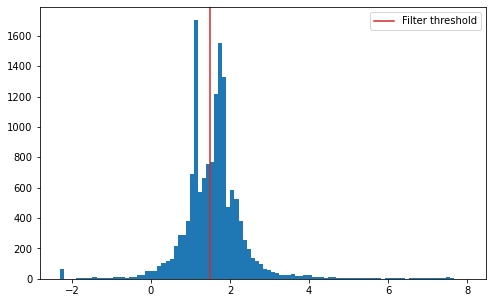

In [5]:
threshold = 1.5

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df.max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [6]:
print("Percent genes removed:", (gene_exp_df.max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df.max() > threshold)
gene_exp_df = gene_exp_df.loc[:, gene_filter]
gene_exp_df

Percent genes removed: 43.80743382252091


,NOC2L,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,CPTP,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGGAGCGTT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,2.601331,-2.302585,0.845987,1.915573,-2.302585,1.237045,-2.302585,1.237045,0.845987,2.067618
KMA1_AAACGGGGTTCGAATC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.247318,-2.302585,-2.302585,...,3.061078,1.292467,2.123950,2.879693,1.292467,1.792248,0.247318,1.573261,0.900638,2.879693
KMA1_AAAGCAATCCAGAGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.159138,-2.302585,...,3.456976,1.529805,2.613873,3.275285,1.928024,2.126047,1.680856,1.928024,-0.159138,3.088015
KMA1_AAATGCCTCCTCAACC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.392738,0.730677,2.680626,3.170434,1.796657,2.159265,1.796657,1.680945,0.730677,2.955224
KMA1_AACCATGTCTTGAGAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.419303,0.665437,2.698856,2.815891,2.698856,1.332545,2.327216,2.232881,0.665437,2.815891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TGTCCCATCTCTTATG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.032224,-2.302585,-2.302585,-2.302585,-2.302585,...,4.465092,1.952505,4.108910,4.164391,3.499383,3.121287,2.860245,3.296466,2.755520,4.191018
KMA7_TGTTCCGAGCGCTTAT,0.096470,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,2.647441,0.096470,2.950957,3.470128,1.809543,1.132637,1.132637,1.630491,-2.302585,2.715962
KMA7_TTAGGACGTGCTAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.127501,-2.302585,-2.302585,-2.302585,-2.302585,...,1.663912,0.775635,1.843072,2.528271,0.775635,2.126788,1.445493,1.165634,-2.302585,1.445493


Differentially expressed genes, by cluster

In [7]:
gene_exp_adata = sc.AnnData(gene_exp_df.iloc[:, :-1], 
                            obs=metadata_df[['diisco_cluster']].astype('str'))
sc.tl.rank_genes_groups(gene_exp_adata, groupby='diisco_cluster', method='wilcoxon', key_added='wilcoxon')

In [8]:
cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group="0", key='wilcoxon')
top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & (cluster_deg_df['scores'] >= 0)]
top_degs.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,GZMH,95.449547,NaN,0.0,0.0
1,CD8A,89.282188,NaN,0.0,0.0
2,CD3E,88.136917,NaN,0.0,0.0
3,CD3D,86.759247,NaN,0.0,0.0
4,IL32,85.840599,NaN,0.0,0.0
5,CD3G,84.605766,NaN,0.0,0.0
6,CD8B,83.116325,NaN,0.0,0.0
7,CCL5,82.967926,NaN,0.0,0.0
8,CD52,80.821373,4.975399,0.0,0.0
9,FGFBP2,75.372063,NaN,0.0,0.0


         Falling back to preprocessing with `sc.pp.pca` and default params.


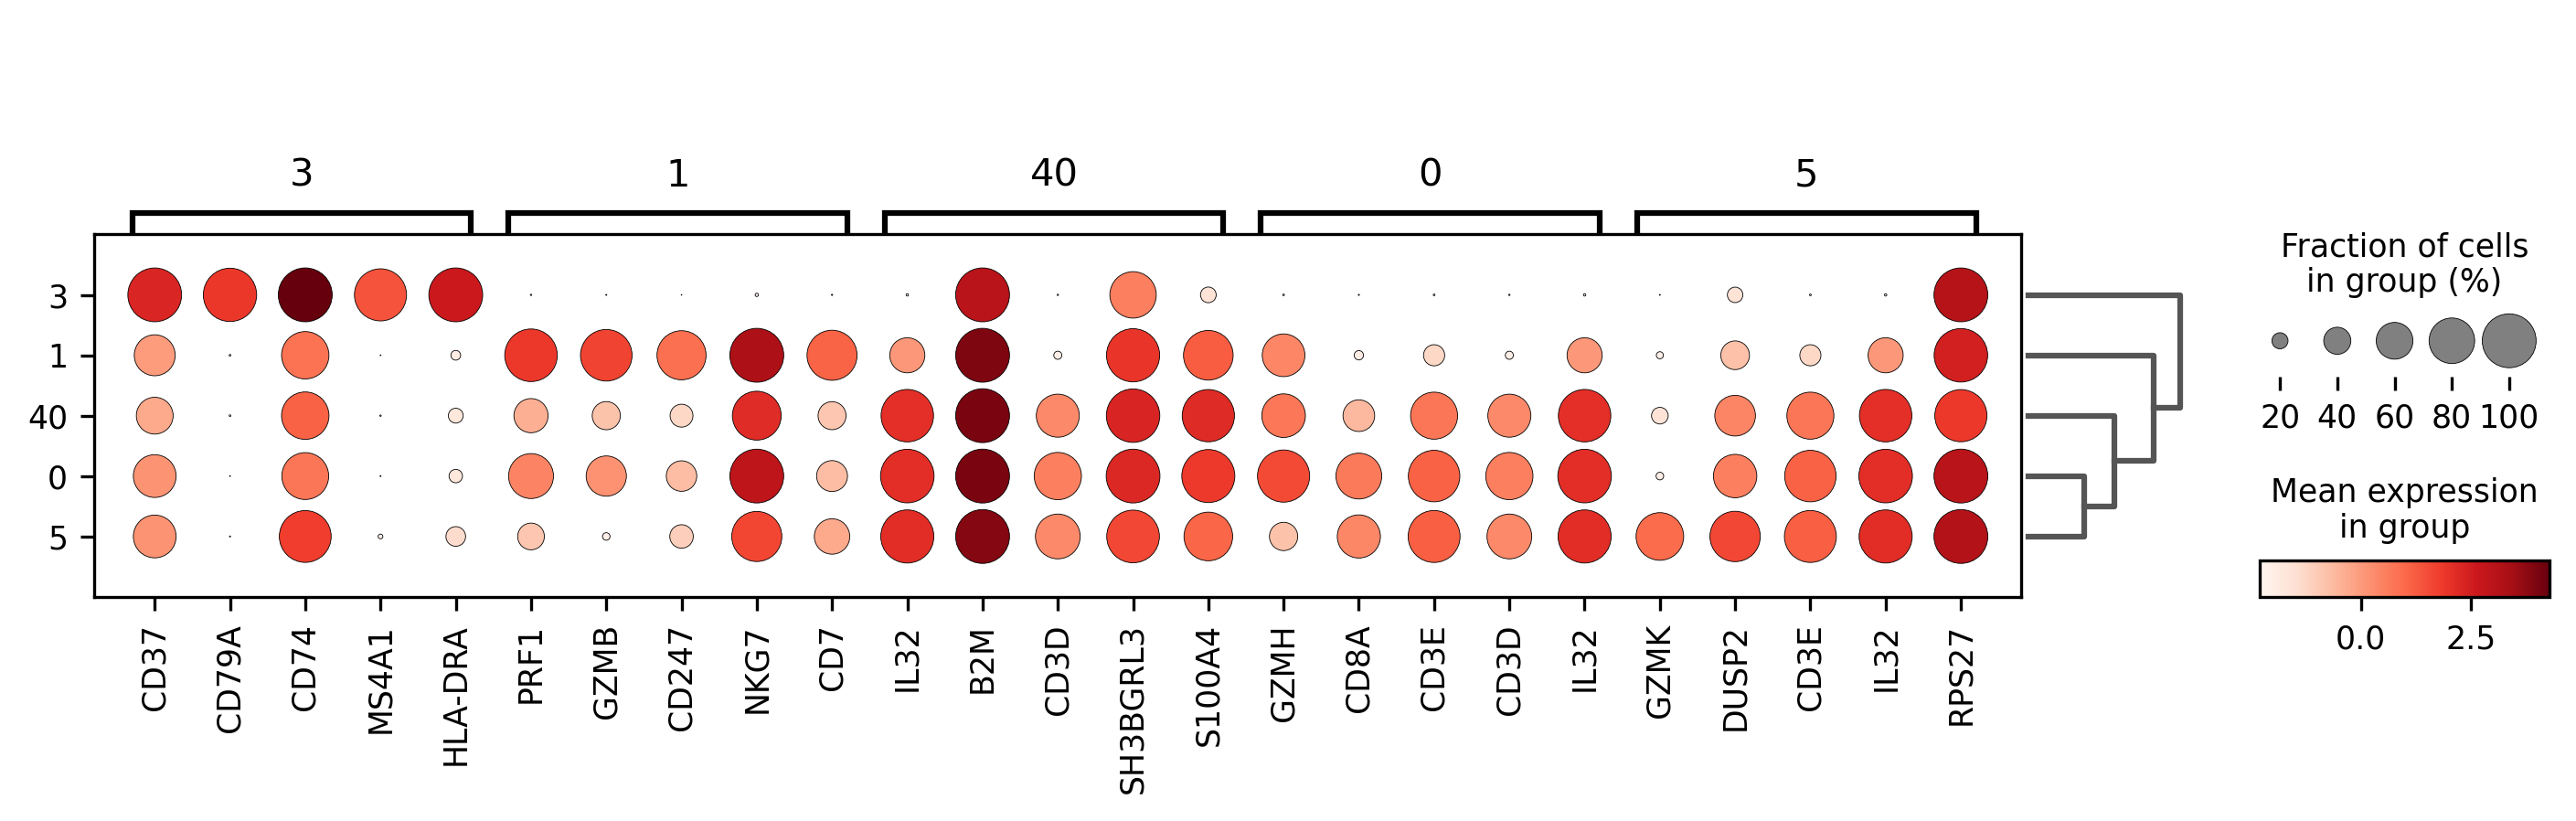

In [9]:
clusters_to_plot = ['0', '1', '3', '5', '40']
with plt.rc_context({"figure.figsize": (10, 10), "figure.dpi": (300)}):
    sc.pl.rank_genes_groups_dotplot(gene_exp_adata[gene_exp_adata.obs['diisco_cluster'].isin(clusters_to_plot)], 
                                    n_genes=5, key='wilcoxon', 
                                    groups=clusters_to_plot)

In [10]:
cluster_to_degs = dict()
writer = pd.ExcelWriter("data/AML/DEGs/cluster_DEGs.xlsx", engine="xlsxwriter")
clusters = sorted(metadata_df['diisco_cluster'].unique())
for cluster in clusters:
    cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group=str(cluster), key='wilcoxon')
    top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & 
                              (cluster_deg_df['scores'] >= 0)]
    cluster_to_degs[cluster] = {
        deg['names']: deg['pvals_adj']
        for index, deg in top_degs.iterrows()
    }
    top_degs.to_excel(writer, sheet_name=f'Cluster {cluster}', index=False)
writer.close()

Load receptor-ligand pairs from Omnipath DB

In [11]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])
# rl_pairs.to_csv('data/RL_pairs/Omnipath_RL_pairs.csv', index=False)
# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
17,Q9H2A7,O00574,CXCL16,CXCR6,True,True,False,True,True,False,20,Baccin2019:11017100;Baccin2019:11290797;Baccin...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,11017100;11290797;14625285;22633458,4,32,20
21,P01579,P15260,IFNG,IFNGR1,True,True,False,True,True,False,58,Baccin2019:10811850;Baccin2019:10986460;Baccin...,Baccin2019;BioGRID;CellCall;CellTalkDB;DIP;DLR...,10811850;10860730;10986460;11250200;12165521;1...,27,33,23
23,P49771,P36888,FLT3LG,FLT3,True,True,False,True,True,False,26,Baccin2019:15147956;Baccin2019:7505204;Baccin2...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,10080542;12681969;15147956;15618475;19830725;2...,9,31,21
39,O43557,P36941,TNFSF14,LTBR,True,True,False,True,True,False,22,Baccin2019:10318773;Baccin2019:10799510;Baccin...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,10318773;10799510;11239407;12571250;26977880;9...,7,36,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7962,P36955,Q9GZT5,SERPINF1,WNT10A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1
7968,Q8N474,Q9GZT5,SFRP1,WNT10A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2
7971,P22692,Q9GZT5,IGFBP4,WNT10A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1
8322,P09486,Q9GZP0,SPARC,PDGFD,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1


Filter gene expressions to RL genes only

In [12]:
all_rl_genes = set(pd.concat([rl_pairs['source_genesymbol'], rl_pairs['target_genesymbol']]))

gene_exp_df = gene_exp_df.loc[:, gene_exp_df.columns.isin(all_rl_genes)]
gene_exp_df

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGGAGCGTT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.194858,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACGGGGTTCGAATC,0.247318,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.247318,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.900638,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAAGCAATCCAGAGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.858084,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-0.159138,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAATGCCTCCTCAACC,-2.302585,-0.275980,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.730677,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.275980,-2.302585
KMA1_AACCATGTCTTGAGAC,0.022417,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.665437,-2.302585,-2.302585,...,-2.302585,0.022417,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TGTCCCATCTCTTATG,-0.032224,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.032224,-2.302585,-2.302585,...,-0.032224,-2.302585,-2.302585,-2.302585,1.669543,-2.302585,-2.302585,-2.302585,-0.032224,-2.302585
KMA7_TGTTCCGAGCGCTTAT,1.412231,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.132637,-2.302585,-2.302585,...,0.096470,-2.302585,-2.302585,-2.302585,1.809543,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAGGACGTGCTAGCC,-2.302585,0.127501,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.663912,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.775635,-2.302585,-2.302585,-2.302585,0.775635,-2.302585


## Responders

In [13]:
gene_exp_responders_df = gene_exp_df[metadata_df['response'] == 'RESPONDER']
metadata_responders_df = metadata_df[metadata_df['response'] == 'RESPONDER']
gene_exp_responders_df

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGGAGCGTT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.194858,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACGGGGTTCGAATC,0.247318,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.247318,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.900638,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAAGCAATCCAGAGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.858084,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-0.159138,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAATGCCTCCTCAACC,-2.302585,-0.275980,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.730677,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.275980,-2.302585
KMA1_AACCATGTCTTGAGAC,0.022417,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.665437,-2.302585,-2.302585,...,-2.302585,0.022417,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TTTGGTTTCCCTAACC,-2.302585,-2.302585,-2.302585,0.004443,0.004443,-2.302585,-2.302585,-0.593797,-2.302585,0.646530,...,-0.593797,-0.593797,-2.302585,-2.302585,1.427925,-2.302585,-2.302585,-2.302585,0.004443,-2.302585
KMA7_TTTGGTTTCCTTTCGG,-2.302585,-2.302585,-2.302585,1.451637,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.781639,...,-2.302585,-2.302585,-2.302585,-2.302585,0.781639,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTTGTCAGTTAAGTAG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.580592,-2.302585,0.580592,...,-2.302585,0.580592,-2.302585,-2.302585,1.924013,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [17]:
X_test = np.load('data/AML/run_1_X_R.npy')
X_test_pre_500_days = (X_test <= 500).flatten()
X_test = X_test[X_test_pre_500_days]

y_preds = np.load('data/AML/run_1_y_preds_R.npy')[X_test_pre_500_days]
W_samples_predict = np.load('data/AML/run_1_W_samples_predict_R.npy')
W = W_samples_predict.mean(axis=0)[X_test_pre_500_days]

# clusters_of_interest = {
#     0: 'T cell', 
#     1: 'B cell', 
#     2: 'NK cell', 
#     3: 'T cell', 
#     4: 'Myeloid', 
#     7: 'T cell', 
#     8: 'Myeloid', 
#     14: 'AML', 
#     16: 'HSC', 
#     19: 'T cell', 
#     21: 'Myeloid', 
#     23: 'AML', 
#     26: 'Myeloid', 
#     28: 'Myeloid', 
#     29: 'Myeloid', 
#     41: 'HSC', 
#     45: 'T cell'
# }

clusters_of_interest = ['0', '1', '13', '2', '20', '26', '3', '35', '40', '5', 'MC1', 'MC2', 'MC3', 'MC4', 'MC7']

Text(0.5, 1.0, '$\\hat{W}_{avg}$ (300 days post DLI)')

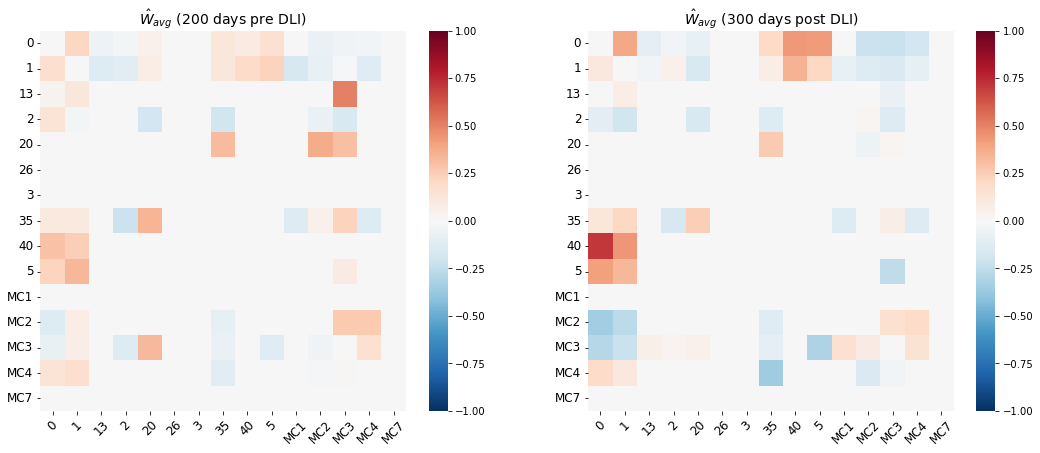

In [19]:
vmin = -1
vmax = 1

X_200_days_pre_dli_index = np.where(X_test > -200)[0][0]
X_post_dli_index = np.where(X_test > 0)[0][0]
X_300_days_post_dli_index = np.where(X_test > 300)[0][0]
X_post_dli_index

W_pre_dli = W[X_200_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_300_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (200 days pre DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (300 days post DLI)', fontsize=14)

In [20]:
source_cluster = '1'
target_cluster = '0'

source_cluster_index = list(clusters_of_interest).index(source_cluster)
target_cluster_index = list(clusters_of_interest).index(target_cluster)

Text(0.5, 1.0, 'Cluster 1 --> 0 interaction (abs val)')

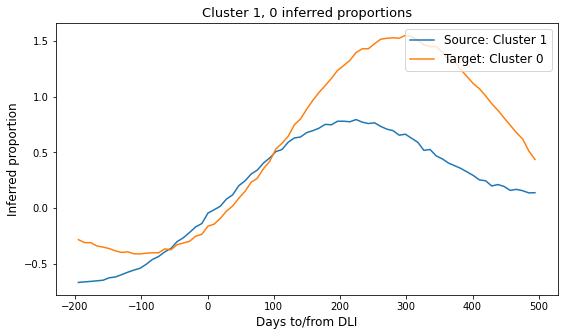

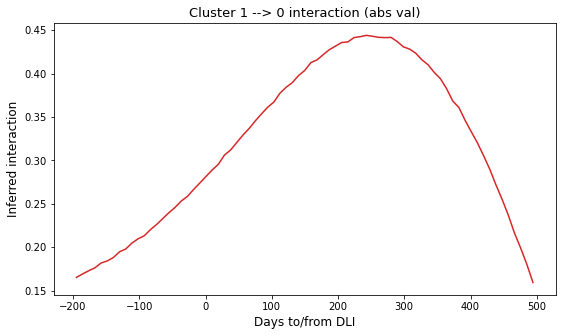

In [21]:
plt.figure(figsize=(9, 5))
plt.plot(X_test, y_preds[:, source_cluster_index], label=f'Source: Cluster {source_cluster}')
plt.plot(X_test, y_preds[:, target_cluster_index], label=f'Target: Cluster {target_cluster}')
plt.ylabel('Inferred proportion', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster}, {target_cluster} inferred proportions', fontsize=13)
plt.legend(loc='upper right', fontsize=12)

plt.figure(figsize=(9, 5))
plt.plot(X_test, np.abs(W[:, target_cluster_index, source_cluster_index]), color='tab:red')
plt.ylabel('Inferred interaction', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)', fontsize=13)

In [22]:
source_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == source_cluster]
source_cluster_cells

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AACTGGTGTGATAAAC,-2.302585,-2.302585,-2.302585,-0.042334,-0.042334,-2.302585,-2.302585,-0.042334,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.984192,-2.302585,-2.302585,-2.302585,-0.042334,-2.302585
KMA1_ACAGCTAAGAGGTAGA,0.482641,-2.302585,-2.302585,-2.302585,-0.150620,-2.302585,-2.302585,0.867320,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.539240,-2.302585,-2.302585,-2.302585,0.482641,-2.302585
KMA1_ACGGCCACAGCTGTAT,-2.302585,-2.302585,-2.302585,-2.302585,-0.240542,-2.302585,-2.302585,0.386896,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,2.120394,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AGATTGCCAGCTGTAT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.204822,-2.302585,-2.302585,...,0.164430,-2.302585,-2.302585,-2.302585,2.166739,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AGCTCTCAGAGTCGGT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.029076,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.888057,-2.302585,-2.302585,-2.302585,0.029076,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TGCGTGGGTAGTACCT,-2.302585,-2.302585,-2.302585,-2.302585,0.992393,-2.302585,-2.302585,2.065982,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.666832,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAGGCAAGCTCCCAG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,2.079977,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,2.079977,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTTACTGAGGGAAACA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.972676,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.972676,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [23]:
target_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == target_cluster]
target_cluster_cells

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AACTCAGTCGGCATCG,1.260805,-2.302585,-2.302585,-2.302585,0.869411,-2.302585,-2.302585,2.444738,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.939679,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_CCTACACGTCAGATAA,-0.468295,-2.302585,-2.302585,-0.468295,-2.302585,-2.302585,-2.302585,1.575802,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.517725,-2.302585,-2.302585,-2.302585,0.790399,-2.302585
KMA1_CGTAGCGAGGCATGTG,1.468329,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.468329,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.468329,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_CTCTGGTAGCTAGCCC,0.719159,-0.286480,-2.302585,0.337760,-0.286480,-2.302585,-2.302585,1.538225,-2.302585,-2.302585,...,-0.286480,-2.302585,-2.302585,-2.302585,0.719159,-2.302585,-2.302585,0.337760,-2.302585,-2.302585
KMA1_CTGAAGTGTAAGAGAG,0.655727,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.540379,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.655727,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TCTGGAAGTACTTCTT,0.027472,-2.302585,-2.302585,-2.302585,1.059026,-2.302585,-2.302585,1.734681,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.027472,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAACTCAGAGGGATA,0.013971,-2.302585,-2.302585,-2.302585,0.013971,-2.302585,-2.302585,2.223617,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.656555,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAGTTCCAAGTAGTA,0.480523,-2.302585,-2.302585,-0.501470,-2.302585,-2.302585,-2.302585,2.102943,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.752622,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


Filter down to differentially-expressed RL genes per cluster

In [24]:
source_cluster_degs = cluster_to_degs[source_cluster]
target_cluster_degs = cluster_to_degs[target_cluster]

Sliding window mean of ligand and receptor expression at DLI time points

In [25]:
min_exp_threshold = -5
sliding_window_length = 2

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_receptor_corrs_with_interaction = []
for index, rl_pair in tqdm_notebook(list(rl_pairs.iterrows())):
    ligand_gene = rl_pair['source_genesymbol']
    receptor_gene = rl_pair['target_genesymbol']
    # Filter to differentially-expressed RL genes
    if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
        continue
    # Model for ligand gene expression
    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(ligand_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
    # Model for receptor gene expression
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(receptor_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
    # Correlations b/w ligand/receptor gene expression and inferred interaction
    ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])
    receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                    source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])
    ligand_receptor_corrs_with_interaction.append({
        'Ligand': ligand_gene,
        'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
        'Ligand DEG pval': source_cluster_degs[ligand_gene],
        'Receptor': receptor_gene,
        'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
        'Receptor DEG pval': target_cluster_degs[receptor_gene],
        'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
    })
    

  0%|          | 0/1074 [00:00<?, ?it/s]

In [26]:
ligand_receptor_corrs_with_interaction_df = pd.DataFrame(ligand_receptor_corrs_with_interaction)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.sort_values('Avg ligand/receptor-interaction correlation', ascending=False)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.reset_index(drop=True)
ligand_receptor_corrs_with_interaction_df.head(25)

,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,TNFRSF14,0.374871,1.645868e-05,CD160,0.727037,6.948193e-16,0.550954
1,SELPLG,0.278723,1.582440e-214,ITGB2,0.679620,5.297592e-282,0.479172
2,CCL5,0.613098,0.000000e+00,CXCR3,0.272057,1.587286e-12,0.442577
3,SPON2,0.124441,0.000000e+00,ITGB2,0.679620,5.297592e-282,0.402031
4,HLA-E,0.450563,0.000000e+00,CD8B,0.348553,0.000000e+00,0.399558
5,HLA-F,0.412816,5.166553e-187,CD8B,0.348553,0.000000e+00,0.380685
6,ICAM2,0.033389,8.776157e-36,ITGB2,0.679620,5.297592e-282,0.356504
7,HLA-E,0.450563,0.000000e+00,CD8A,0.243097,0.000000e+00,0.346830
8,HLA-F,0.412816,5.166553e-187,CD8A,0.243097,0.000000e+00,0.327956
9,ADAM10,-0.082391,1.552014e-23,TSPAN14,0.729427,3.614522e-80,0.323518


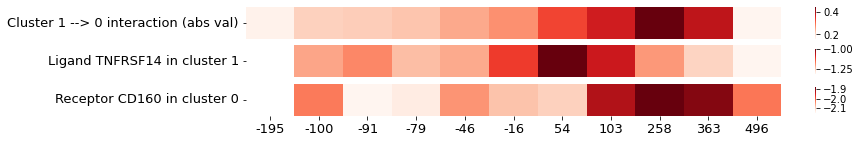

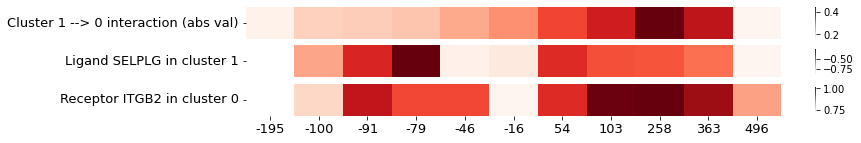

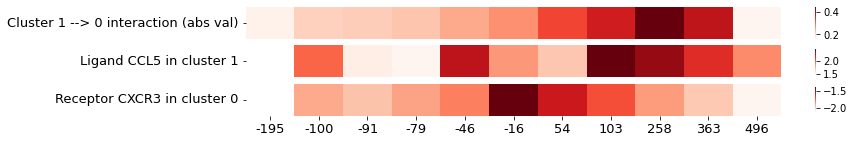

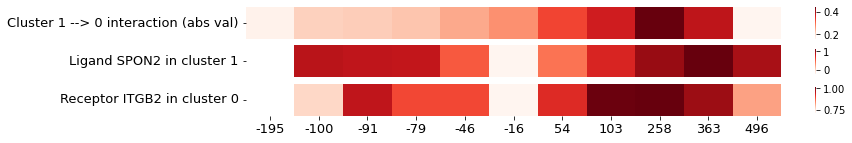

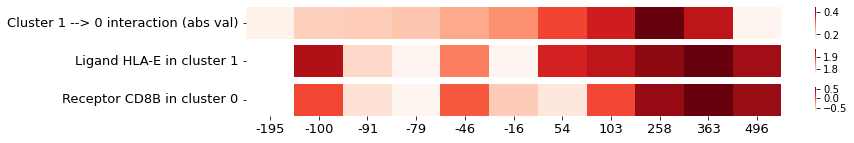

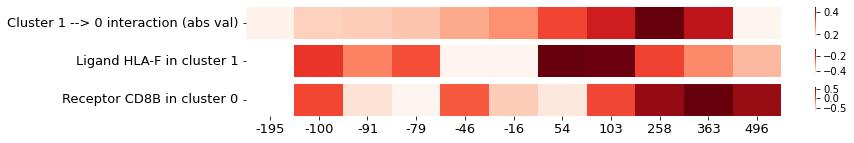

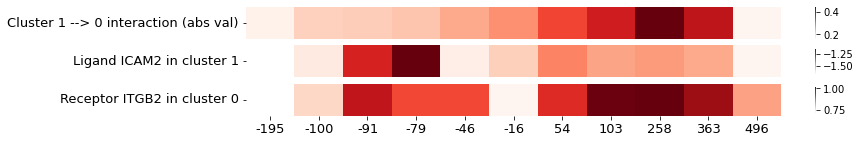

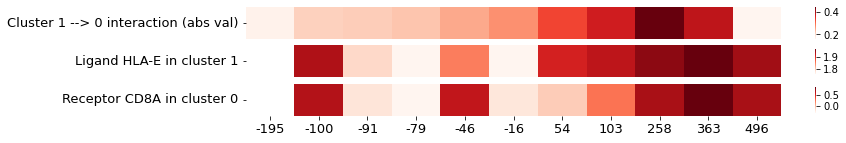

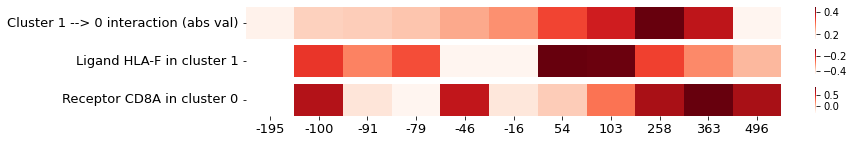

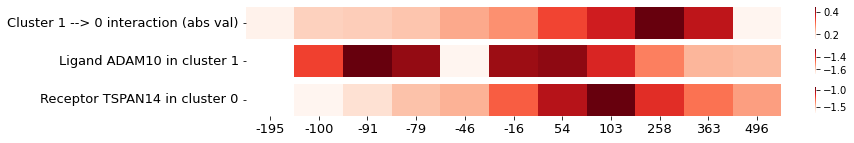

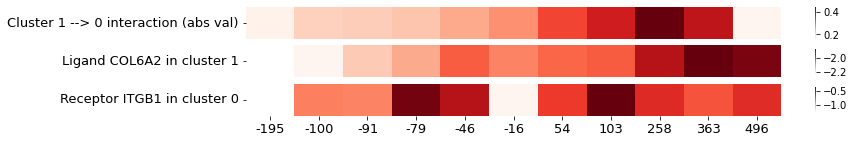

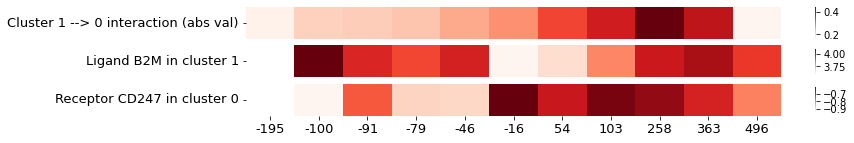

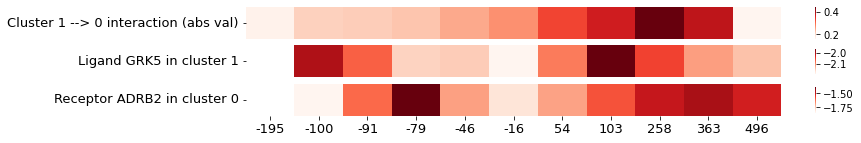

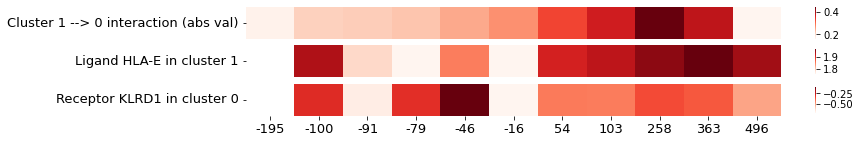

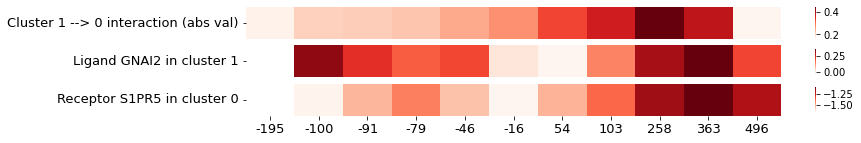

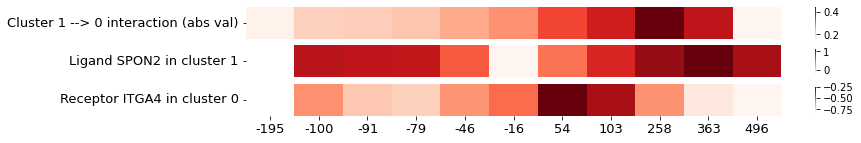

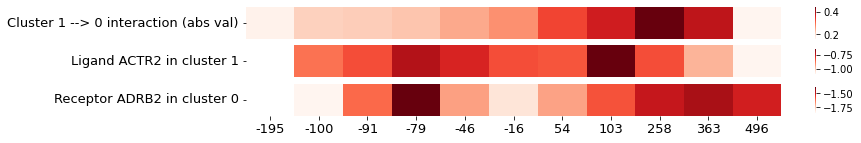

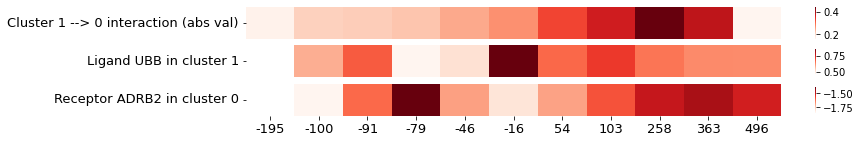

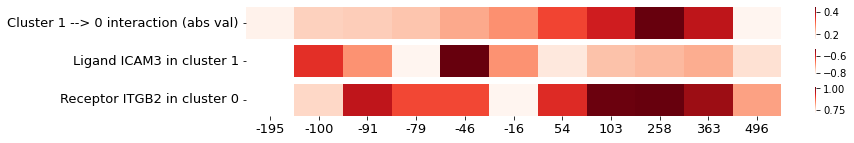

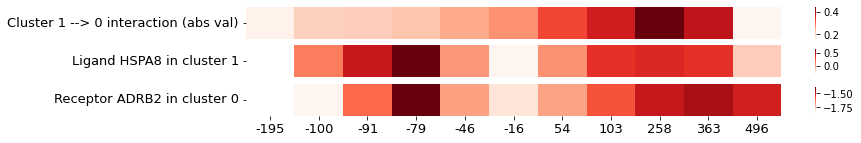

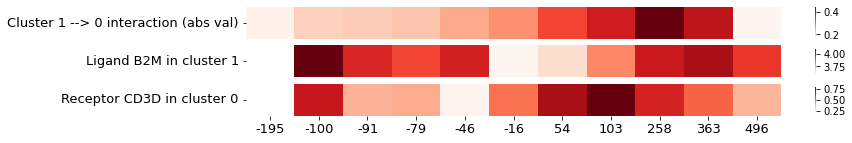

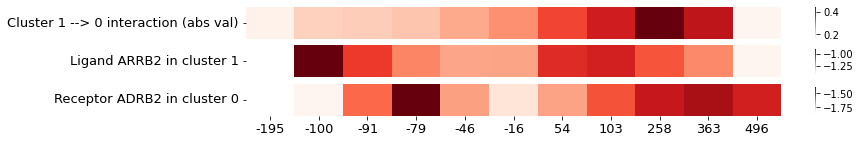

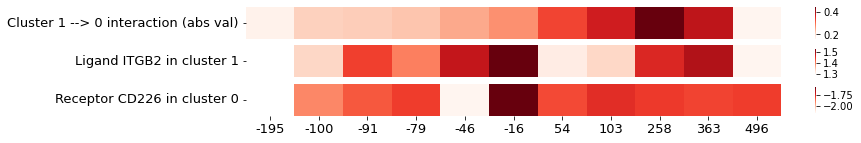

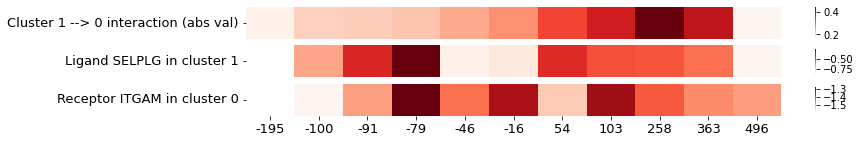

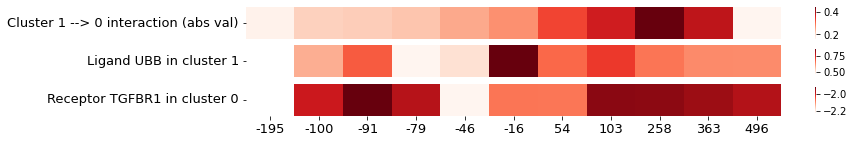

In [27]:
for index, rl_pair in ligand_receptor_corrs_with_interaction_df.head(25).iterrows():
    ligand_gene = rl_pair['Ligand']
    receptor_gene = rl_pair['Receptor']

    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
    
    days_to_dli = sorted(set(ligand_days_to_dli.unique()).intersection(receptor_days_to_dli.unique()))
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)

    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
    
    rl_expression = pd.DataFrame(np.vstack([sliding_window_mean_ligand_gene_exp, 
                                            sliding_window_mean_receptor_gene_exp]), 
                                 columns=days_to_dli)
    rl_expression.index = [f'Ligand {ligand_gene} in cluster {source_cluster}', 
                           f'Receptor {receptor_gene} in cluster {target_cluster}']

    plt.figure(figsize=(12, 2))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 
    plt.subplot(gs[0])
    g = sns.heatmap([source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates]], 
                    xticklabels=sliding_window_mean_ligand_gene_exp.index,
                    yticklabels=[f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)'],
                    cmap='Reds', cbar_kws={"shrink": 1})
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[1])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[0]).T, cmap='Reds', cbar_kws={"shrink": 0.8})
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[2])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[1]).T, cmap='Reds', cbar_kws={"shrink": 0.8})
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels(g.get_xticklabels(), size = 13, rotation=0)
#     plt.savefig(f'figures/AML_paper/top_RL_pairs/top_RL_pairs_cluster_14_to_cluster_0_R_{index}.eps', 
#                 bbox_inches='tight')

In [28]:
ligand_gene = 'TNFRSF14'
receptor_gene = 'CD160'

min_exp_threshold = -5
sliding_window_length = 2

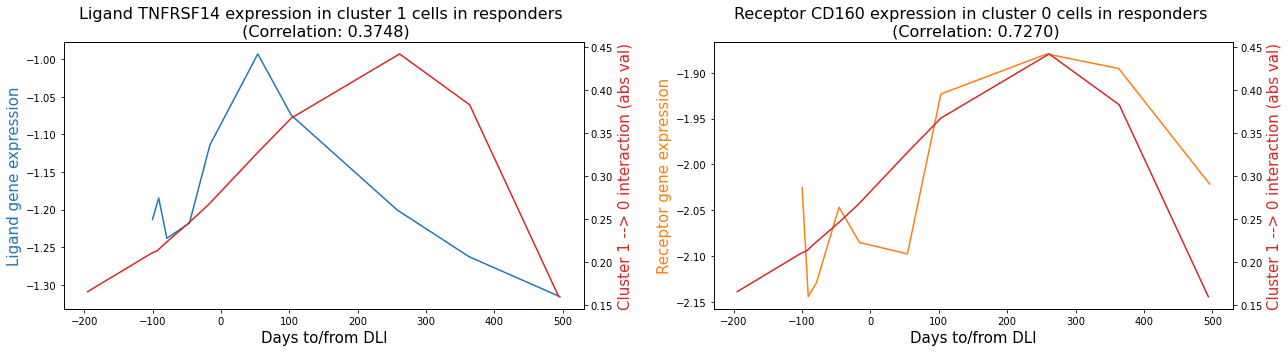

In [29]:
min_exp_threshold = -5

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(ligand_days_to_dli.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
# ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(receptor_days_to_dli.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
# ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('figures/AML_paper/example_top_RL_pair_R.eps')

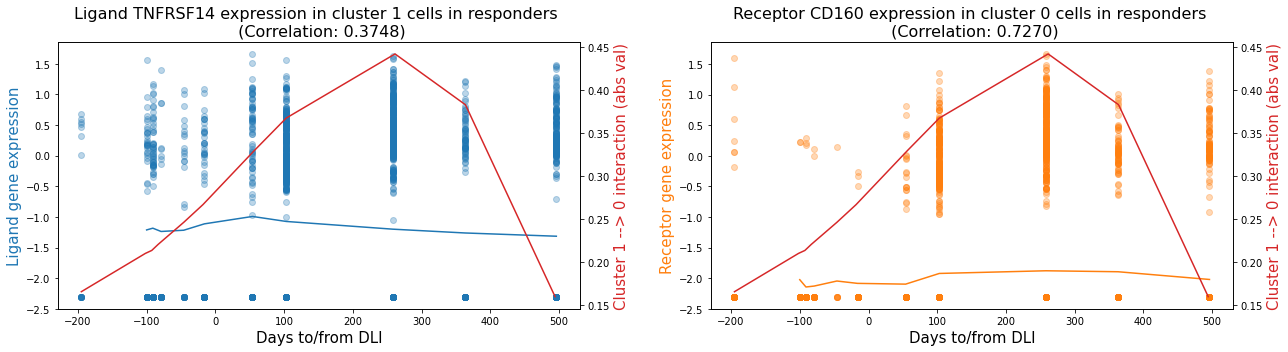

In [30]:
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(ligand_days_to_dli.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(receptor_days_to_dli.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('figures/AML_paper/example_top_RL_pair_R.eps')

Compute RL-interaction correlations for all cluster pairs

In [32]:
min_exp_threshold = -5
sliding_window_length = 2

ligand_receptor_corrs_with_interaction = []
for source_cluster in tqdm_notebook(clusters_of_interest):
    for target_cluster in clusters_of_interest:
        if source_cluster not in cluster_to_degs or target_cluster not in cluster_to_degs: continue
        source_target_rl_corrs_with_interaction = []
        print(source_cluster, target_cluster)
        
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        source_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == source_cluster]
        source_cluster_degs = cluster_to_degs[source_cluster]
        
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        target_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == target_cluster]
        target_cluster_degs = cluster_to_degs[target_cluster]

        source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

        for index, rl_pair in rl_pairs.iterrows():
            ligand_gene = rl_pair['source_genesymbol']
            receptor_gene = rl_pair['target_genesymbol']
            # Filter to differentially-expressed RL genes
            if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
                continue
            # Model for ligand gene expression
            ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
            ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
            days_to_dli = sorted(ligand_days_to_dli.unique())
            if len(days_to_dli) < sliding_window_length: continue
            sliding_window_mean_ligand_gene_exp = pd.Series({
                days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(days_to_dli)
            })
            ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
            for days in sliding_window_mean_ligand_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
            # Model for receptor gene expression
            receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
            receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
            days_to_dli = sorted(receptor_days_to_dli.unique())
            if len(days_to_dli) < sliding_window_length: continue
            sliding_window_mean_receptor_gene_exp = pd.Series({
                days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(days_to_dli)
            })
            receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
            for days in sliding_window_mean_receptor_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
            # Correlations b/w ligand/receptor gene expression and inferred interaction
            ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                        source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])
            receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                            source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])
            source_target_rl_corrs_with_interaction.append({
                'Source cluster': source_cluster,
                'Target cluster': target_cluster,
                'Ligand': ligand_gene,
                'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
                'Ligand DEG pval': source_cluster_degs[ligand_gene],
                'Receptor': receptor_gene,
                'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
                'Receptor DEG pval': target_cluster_degs[receptor_gene],
                'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
            })
        source_target_rl_corrs_with_interaction_df = pd.DataFrame(source_target_rl_corrs_with_interaction)
        if source_target_rl_corrs_with_interaction_df.shape[0] == 0: continue
        source_target_rl_corrs_with_interaction_df = pd.merge(source_target_rl_corrs_with_interaction_df, 
                                                              rl_pairs[['source_genesymbol', 'target_genesymbol', 'n_references', 'n_sources']], 
                                                              how='left', left_on=['Ligand', 'Receptor'], 
                                                              right_on=['source_genesymbol', 'target_genesymbol'])
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.drop(columns=['source_genesymbol', 'target_genesymbol', 
                                                                                                              'Source cluster', 'Target cluster'])
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.sort_values('Avg ligand/receptor-interaction correlation', ascending=False)
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.reset_index(drop=True)
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.head(30)
        source_target_rl_corrs_with_interaction_df.to_excel(f'data/AML/DIISCO_AML_top_RL_pairs_R/{source_cluster} --> {target_cluster}.xlsx', 
                                                            sheet_name='R',
                                                            index=False)
        ligand_receptor_corrs_with_interaction.extend(source_target_rl_corrs_with_interaction)


  0%|          | 0/15 [00:00<?, ?it/s]

0 0
0 1
0 13
0 2
0 20
0 26
0 3
0 40
0 5
0 MC1
0 MC2
0 MC3
0 MC4
0 MC7
1 0
1 1
1 13
1 2
1 20
1 26
1 3
1 40
1 5
1 MC1
1 MC2
1 MC3
1 MC4
1 MC7
13 0
13 1
13 13
13 2
13 20
13 26
13 3
13 40
13 5
13 MC1
13 MC2
13 MC3
13 MC4
13 MC7
2 0
2 1
2 13
2 2
2 20
2 26
2 3
2 40
2 5
2 MC1
2 MC2
2 MC3
2 MC4
2 MC7
20 0
20 1
20 13
20 2
20 20
20 26
20 3
20 40
20 5
20 MC1
20 MC2
20 MC3
20 MC4
20 MC7
26 0
26 1
26 13
26 2
26 20
26 26
26 3
26 40
26 5
26 MC1
26 MC2
26 MC3
26 MC4
26 MC7
3 0
3 1
3 13
3 2
3 20
3 26
3 3
3 40
3 5
3 MC1
3 MC2
3 MC3
3 MC4
3 MC7
40 0
40 1
40 13
40 2
40 20
40 26
40 3
40 40
40 5
40 MC1
40 MC2
40 MC3
40 MC4
40 MC7
5 0
5 1
5 13
5 2
5 20
5 26
5 3
5 40
5 5
5 MC1
5 MC2
5 MC3
5 MC4
5 MC7
MC1 0
MC1 1
MC1 13
MC1 2
MC1 20
MC1 26
MC1 3
MC1 40
MC1 5
MC1 MC1
MC1 MC2
MC1 MC3
MC1 MC4
MC1 MC7
MC2 0
MC2 1
MC2 13
MC2 2
MC2 20
MC2 26
MC2 3
MC2 40
MC2 5
MC2 MC1
MC2 MC2
MC2 MC3
MC2 MC4
MC2 MC7
MC3 0
MC3 1
MC3 13
MC3 2
MC3 20
MC3 26
MC3 3
MC3 40
MC3 5
MC3 MC1
MC3 MC2
MC3 MC3
MC3 MC4
MC3 MC7
MC4 0
MC4 1
MC4 13
M

In [45]:
ligand_receptor_corrs_with_interaction_df = pd.DataFrame(ligand_receptor_corrs_with_interaction)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.\
    sort_values(['Source cluster', 'Target cluster', 'Avg ligand/receptor-interaction correlation'], 
                ascending= [True, True, False])
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.dropna()
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.reset_index(drop=True)
ligand_receptor_corrs_with_interaction_df.to_csv('data/AML/rl_interaction_correlations_R.csv', index=False)
ligand_receptor_corrs_with_interaction_df

,Source cluster,Target cluster,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,0,1,ADRB2,0.383604,5.307391e-130,CXCR4,0.455738,0.000000e+00,0.419671
1,0,1,CALR,0.356589,1.496932e-24,HLA-F,0.213202,1.862821e-18,0.284895
2,0,1,TGFB1,0.066856,0.000000e+00,CXCR4,0.455738,0.000000e+00,0.261297
3,0,1,CD99,0.629587,0.000000e+00,CD81,-0.169688,3.630826e-188,0.229950
4,0,1,B2M,0.115672,0.000000e+00,HLA-F,0.213202,1.862821e-18,0.164437
...,...,...,...,...,...,...,...,...,...
10488,45,7,HLA-B,-0.601151,1.073420e-03,CD3D,0.120999,1.482551e-205,-0.240076
10489,45,7,KLRD1,-0.106789,2.745725e-11,HLA-E,-0.380629,3.551744e-126,-0.243709
10490,45,7,HLA-B,-0.601151,1.073420e-03,CD3G,0.044122,5.616247e-135,-0.278515
10491,45,7,HLA-B,-0.601151,1.073420e-03,KLRD1,-0.046701,2.970951e-26,-0.323926


In [46]:
ligand_receptor_corrs_with_interaction_df = pd.read_csv('data/AML/rl_interaction_correlations_R.csv')
ligand_receptor_corrs_with_interaction_df

,Source cluster,Target cluster,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,0,1,ADRB2,0.383604,5.307391e-130,CXCR4,0.455738,0.000000e+00,0.419671
1,0,1,CALR,0.356589,1.496932e-24,HLA-F,0.213202,1.862821e-18,0.284895
2,0,1,TGFB1,0.066856,0.000000e+00,CXCR4,0.455738,0.000000e+00,0.261297
3,0,1,CD99,0.629587,0.000000e+00,CD81,-0.169688,3.630826e-188,0.229950
4,0,1,B2M,0.115672,0.000000e+00,HLA-F,0.213202,1.862821e-18,0.164437
...,...,...,...,...,...,...,...,...,...
10488,45,7,HLA-B,-0.601151,1.073420e-03,CD3D,0.120999,1.482551e-205,-0.240076
10489,45,7,KLRD1,-0.106789,2.745725e-11,HLA-E,-0.380629,3.551744e-126,-0.243709
10490,45,7,HLA-B,-0.601151,1.073420e-03,CD3G,0.044122,5.616247e-135,-0.278515
10491,45,7,HLA-B,-0.601151,1.073420e-03,KLRD1,-0.046701,2.970951e-26,-0.323926


### Agreement between DIISCO and CellPhoneDB

In [47]:
cellphonedb_aml_r_pre = pd.read_csv('data/AML/cellphonedb_output/aml_r_pre-2.csv', index_col='Unnamed: 0')
cellphonedb_aml_r_pre['cluster_L'] = cellphonedb_aml_r_pre['cluster_L'].str.split('_').str[1].astype(int)
cellphonedb_aml_r_pre['cluster_R'] = cellphonedb_aml_r_pre['cluster_R'].str.split('_').str[1].astype(int)
cellphonedb_aml_r_pre = cellphonedb_aml_r_pre[(cellphonedb_aml_r_pre['cluster_L'].isin(clusters_of_interest)) & 
                                              (cellphonedb_aml_r_pre['cluster_R'].isin(clusters_of_interest))]
cellphonedb_aml_r_pre['p-val'] = -np.log1p(cellphonedb_aml_r_pre['p-val'])
cellphonedb_aml_r_pre

,cluster_L,cluster_R,Ligand,Receptor,mean_logexp_L,mean_logexp_R,p-val
0,0,1,CCL4,CNR2,-0.429541,-2.068809,-0.0
1,0,1,PTPRC,CD22,0.454621,-0.998551,-0.0
2,0,1,ADGRG5,FAM3C,-2.137795,-1.790596,-0.0
3,0,1,CD52,SIGLEC10,1.987244,-2.107780,-0.0
4,0,1,CD160,TNFRSF14,-1.882195,-1.575845,-0.0
...,...,...,...,...,...,...,...
16965,8,7,LTBR,LTB,-2.126006,-0.709210,-0.0
16966,8,7,PLXNB2,SEMA4D,-2.066142,-1.908303,-0.0
16967,8,7,MIF,TNFRSF14,-0.583595,-1.748294,-0.0
16968,8,7,ICAM2,aLb2 complex,NaN,NaN,-0.0


In [48]:
num_sig_interactions_by_clusters_pre = []

for i, group in cellphonedb_aml_r_pre.groupby(['cluster_L', 'cluster_R']):
    source_cluster, target_cluster = i
    num_sig_interactions = group.shape[0]
    num_sig_interactions_by_clusters_pre.append({
        'Source cluster': source_cluster,
        'Target cluster': target_cluster,
        'Number of significant interactions': num_sig_interactions,
        'Average -log(p-value)': group['p-val'].mean(),
        'Average RL log exp': group[['mean_logexp_L', 'mean_logexp_R']].mean().mean()
    })
    
num_sig_interactions_by_clusters_pre = pd.DataFrame(num_sig_interactions_by_clusters_pre)
num_sig_interactions_by_clusters_pre.sort_values('Number of significant interactions', ascending=False).head(10)

,Source cluster,Target cluster,Number of significant interactions,Average -log(p-value),Average RL log exp
162,21,2,40,-0.002362,-1.345921
194,26,2,36,-0.002196,-1.208590
171,21,26,36,-0.002312,-0.939917
73,4,21,34,-0.004632,-1.590234
66,4,2,34,0.000000,-1.454202
242,41,2,33,-0.000963,-1.643829
226,29,2,33,-0.001916,-1.213930
130,16,2,32,-0.003079,-1.698271
178,23,2,32,-0.001226,-1.273380
202,26,21,31,-0.002950,-1.248522


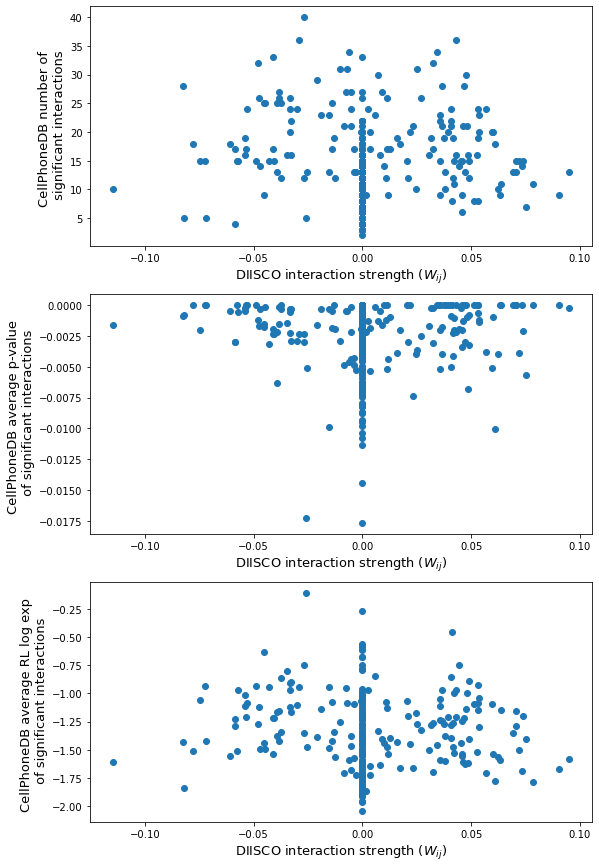

In [49]:
plt.figure(figsize=(9, 15)) 

plt.subplot(3, 1, 1)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Number of significant interactions'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB number of \n significant interactions', fontsize=13)
        
plt.subplot(3, 1, 2)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average p-value \n of significant interactions', fontsize=13)
        
plt.subplot(3, 1, 3)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average RL log exp'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average RL log exp \n of significant interactions', fontsize=13)

In [50]:
cellphonedb_aml_r_post = pd.read_csv('data/AML/cellphonedb_output/aml_r_post-2.csv', index_col='Unnamed: 0')
cellphonedb_aml_r_post['cluster_L'] = cellphonedb_aml_r_post['cluster_L'].str.split('_').str[1].astype(int)
cellphonedb_aml_r_post['cluster_R'] = cellphonedb_aml_r_post['cluster_R'].str.split('_').str[1].astype(int)
cellphonedb_aml_r_post = cellphonedb_aml_r_post[(cellphonedb_aml_r_post['cluster_L'].isin(clusters_of_interest)) & 
                                                (cellphonedb_aml_r_post['cluster_R'].isin(clusters_of_interest))]
cellphonedb_aml_r_post['p-val'] = -np.log1p(cellphonedb_aml_r_post['p-val'])
cellphonedb_aml_r_post

,cluster_L,cluster_R,Ligand,Receptor,mean_logexp_L,mean_logexp_R,p-val
0,0,1,IFNG,Type II IFNR,NaN,NaN,-0.000000
1,0,1,CD52,SIGLEC10,1.987244,-2.107780,-0.000000
2,0,1,CCL4,CNR2,-0.429541,-2.068809,-0.000000
3,0,1,ADGRG5,FAM3C,-2.137795,-1.790596,-0.000000
4,0,1,ADRB2,VEGFB,-1.920954,-1.993654,-0.000000
...,...,...,...,...,...,...,...
16657,8,7,LTBR,LTB,-2.126006,-0.709210,-0.000000
16658,8,7,ICAM2,aLb2 complex,NaN,NaN,-0.027615
16659,8,7,PLXNB2,SEMA4D,-2.066142,-1.908303,-0.000000
16660,8,7,LGALS9,CD44,-1.803414,-0.977957,-0.000000


In [51]:
num_sig_interactions_by_clusters_post = []

for i, group in cellphonedb_aml_r_post.groupby(['cluster_L', 'cluster_R']):
    source_cluster, target_cluster = i
    num_sig_interactions = group.shape[0]
    num_sig_interactions_by_clusters_post.append({
        'Source cluster': source_cluster,
        'Target cluster': target_cluster,
        'Number of significant interactions': num_sig_interactions,
        'Average -log(p-value)': group['p-val'].mean(),
        'Average RL log exp': group[['mean_logexp_L', 'mean_logexp_R']].mean().mean()
    })
    
num_sig_interactions_by_clusters_post = pd.DataFrame(num_sig_interactions_by_clusters_post)
num_sig_interactions_by_clusters_post.sort_values('Number of significant interactions', ascending=False).head(10)

,Source cluster,Target cluster,Number of significant interactions,Average -log(p-value),Average RL log exp
71,4,26,44,-0.001256,-1.249818
182,26,2,43,-0.000647,-1.190857
161,21,26,41,-0.000582,-0.998002
131,16,26,39,-0.001014,-1.450337
184,26,4,37,-0.001593,-1.237971
152,21,2,36,-0.000963,-1.394743
190,26,21,35,-0.002376,-1.016496
62,4,2,35,-0.000228,-1.596391
188,26,16,32,-0.000623,-1.148356
222,29,26,32,-0.002014,-1.032939


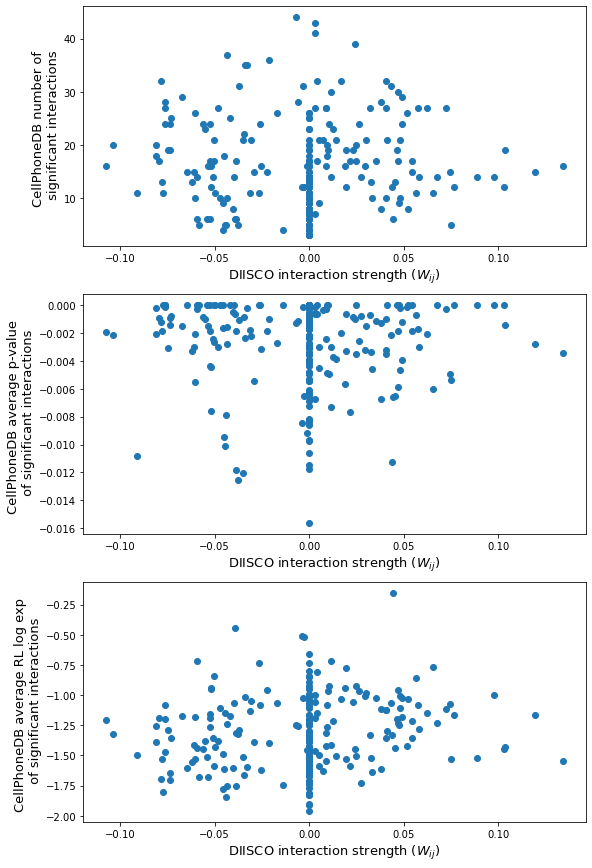

In [52]:
plt.figure(figsize=(9, 15)) 

plt.subplot(3, 1, 1)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Number of significant interactions'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB number of \n significant interactions', fontsize=13)
        
plt.subplot(3, 1, 2)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average p-value \n of significant interactions', fontsize=13)
        
plt.subplot(3, 1, 3)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average RL log exp'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average RL log exp \n of significant interactions', fontsize=13)

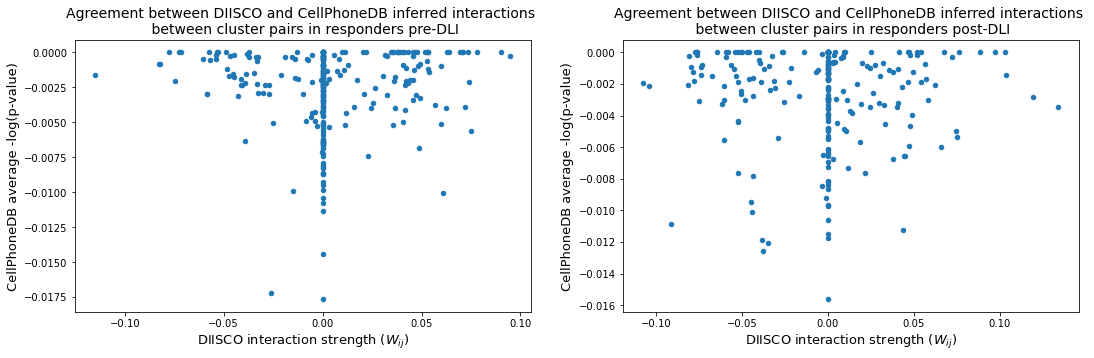

In [53]:
plt.figure(figsize=(18, 5)) 

plt.subplot(1, 2, 1)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=20)
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in responders pre-DLI', 
                  fontsize=14)
        
plt.subplot(1, 2, 2)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=20)
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in responders post-DLI', 
                  fontsize=14)

plt.savefig('figures/AML_paper/agreement_diisco_cellphonedb_R.eps')

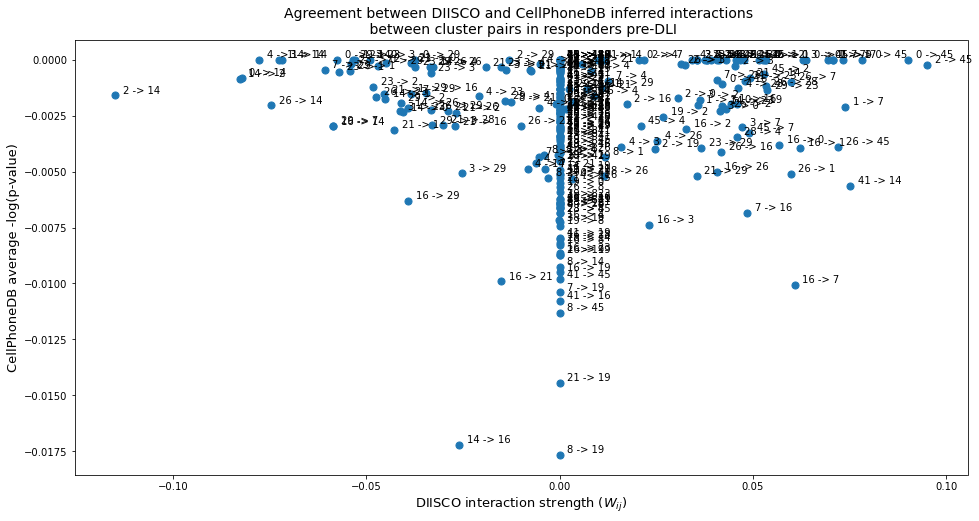

In [54]:
plt.figure(figsize=(16, 8)) 
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=50)
        plt.annotate(f'{source_cluster} -> {target_cluster}', 
                     (W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index] + 0.002, 
                      cellphonedb_cluster_pair['Average -log(p-value)'] + 0.0001,))
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in responders pre-DLI', 
                  fontsize=14)
plt.savefig('figures/AML_paper/agreement_diisco_cellphonedb_pre_R.eps')

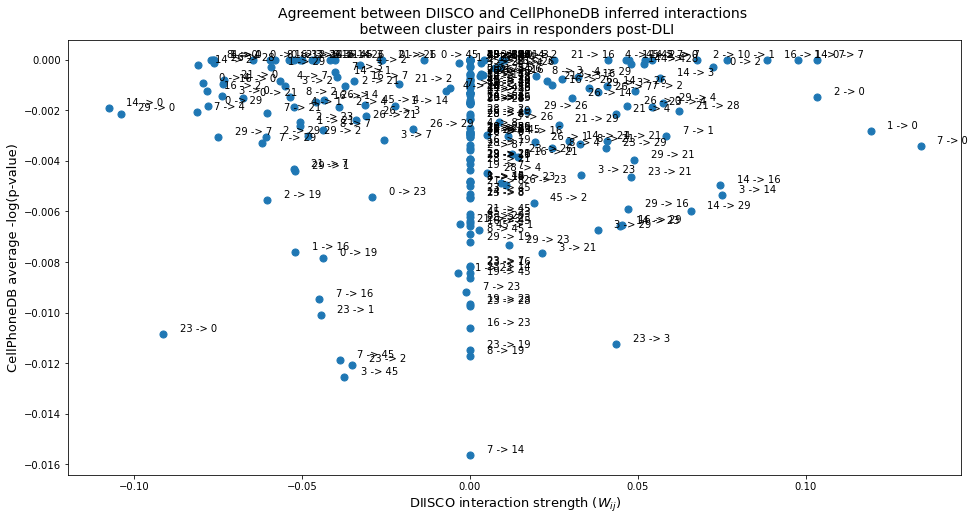

In [55]:
plt.figure(figsize=(16, 8)) 
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=50)
        plt.annotate(f'{source_cluster} -> {target_cluster}', 
                     (W_post_dli_avg_over_time[target_cluster_index, source_cluster_index] + 0.005, 
                      cellphonedb_cluster_pair['Average -log(p-value)'] + 0.0001,))
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in responders post-DLI', 
                  fontsize=14)
        
plt.savefig('figures/AML_paper/agreement_diisco_cellphonedb_post_R.eps')

## Non-responders

In [33]:
gene_exp_nonresponders_df = gene_exp_df[metadata_df['response'] == 'NONRESPONDER']
metadata_nonresponders_df = metadata_df[metadata_df['response'] == 'NONRESPONDER']
gene_exp_nonresponders_df

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGCACCCAGTG,-0.162941,0.469556,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.347608,-2.302585,-2.302585,...,-0.162941,-2.302585,-2.302585,-2.302585,-0.162941,-2.302585,-2.302585,-2.302585,-0.162941,-2.302585
KMA1_AAACCTGCATCAGTCA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.850078,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.343660,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACCTGGTGATGATA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.337885,-0.171744,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.460199,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACCTGTCAGTTAGC,-0.903244,-2.302585,-2.302585,-0.341778,0.278398,-2.302585,-2.302585,1.403222,-2.302585,-0.341778,...,-2.302585,0.015636,-2.302585,-2.302585,0.932960,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACGGGGTCAACATC,-2.302585,-2.302585,-2.302585,-1.271624,-1.271624,-2.302585,-2.302585,-2.302585,-1.271624,-2.302585,...,-2.302585,-1.271624,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TGTCCCATCTCTTATG,-0.032224,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.032224,-2.302585,-2.302585,...,-0.032224,-2.302585,-2.302585,-2.302585,1.669543,-2.302585,-2.302585,-2.302585,-0.032224,-2.302585
KMA7_TGTTCCGAGCGCTTAT,1.412231,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.132637,-2.302585,-2.302585,...,0.096470,-2.302585,-2.302585,-2.302585,1.809543,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAGGACGTGCTAGCC,-2.302585,0.127501,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.663912,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.775635,-2.302585,-2.302585,-2.302585,0.775635,-2.302585


In [34]:
X_test = np.load('data/AML/run_1_X_NR.npy')
y_preds = np.load('data/AML/run_1_y_preds_NR.npy')
W_samples_predict = np.load('data/AML/run_1_W_samples_predict_NR.npy')
W = W_samples_predict.mean(axis=0)

# clusters_of_interest = {
#     0: 'T cell', 
#     1: 'B cell', 
#     2: 'NK cell', 
#     3: 'T cell', 
#     4: 'Myeloid', 
#     6: 'Erythroid',
#     7: 'T cell', 
#     8: 'Myeloid', 
#     11: 'B cell',
#     14: 'AML', 
#     15: 'NK cell',
#     16: 'HSC', 
#     20: 'Erythroid',
#     21: 'Myeloid', 
#     23: 'AML', 
#     24: 'B cell',
#     26: 'Myeloid', 
#     28: 'Myeloid', 
#     29: 'Myeloid', 
#     36: 'NK cell',
#     45: 'T cell'
# }

clusters_of_interest = ['0', '1', '13', '14', '2', '23', '26', '3', '38', '40', '5', 'MC1', 'MC2', 'MC3', 'MC4', 'MC5', 'MC6', 'MC7']

Text(0.5, 1.0, '$\\hat{W}_{avg}$ (100 days post DLI)')

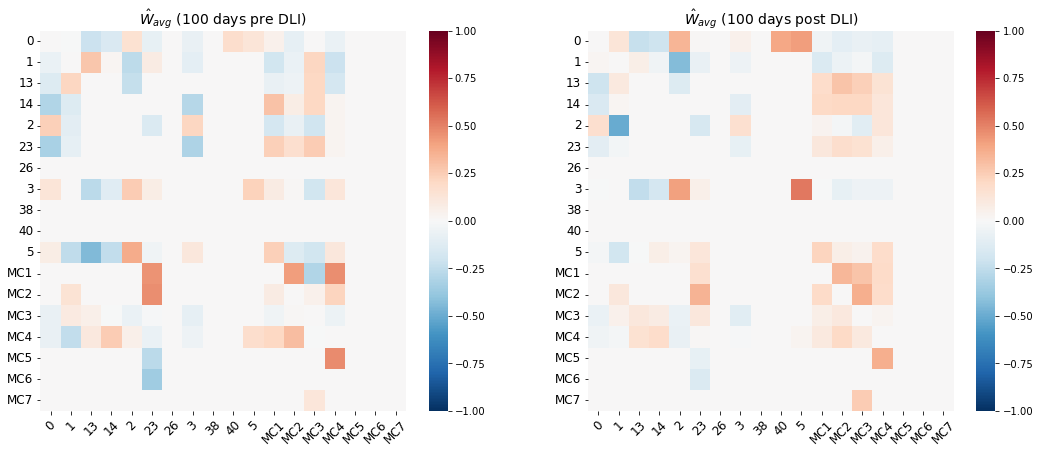

In [35]:
vmin = -1
vmax = 1

X_100_days_pre_dli_index = np.where(X_test > -100)[0][0]
X_post_dli_index = np.where(X_test > 0)[0][0]
X_100_days_post_dli_index = np.where(X_test > 97)[0][0]
X_post_dli_index

W_pre_dli = W[X_100_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_100_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (100 days pre DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (100 days post DLI)', fontsize=14)

In [36]:
source_cluster = '5'
target_cluster = '3'

source_cluster_index = list(clusters_of_interest).index(source_cluster)
target_cluster_index = list(clusters_of_interest).index(target_cluster)

Text(0.5, 1.0, 'Cluster 5 --> 3 interaction (abs val)')

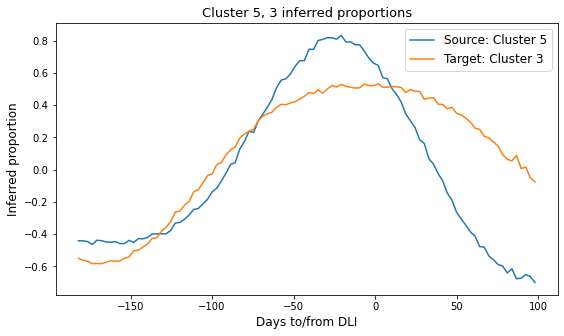

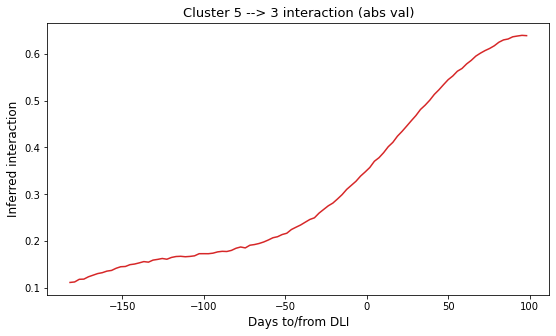

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(X_test, y_preds[:, source_cluster_index], label=f'Source: Cluster {source_cluster}')
plt.plot(X_test, y_preds[:, target_cluster_index], label=f'Target: Cluster {target_cluster}')
plt.ylabel('Inferred proportion', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster}, {target_cluster} inferred proportions', fontsize=13)
plt.legend(loc='upper right', fontsize=12)

plt.figure(figsize=(9, 5))
plt.plot(X_test, np.abs(W[:, target_cluster_index, source_cluster_index]), color='tab:red')
plt.ylabel('Inferred interaction', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)', fontsize=13)

In [38]:
source_cluster_cells = gene_exp_nonresponders_df[metadata_nonresponders_df['diisco_cluster'] == source_cluster]
source_cluster_cells

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACGGGTCTAACGGT,0.153801,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.871426,0.153801,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.153801,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAAGATGTCCGGCACA,0.339496,0.339496,-2.302585,0.339496,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.670901,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAAGTAGGTCAAAGAT,-0.009325,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.019625,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_ACGGGCTGTACCGTAT,0.050479,-2.302585,-2.302585,-2.302585,0.050479,-2.302585,-2.302585,1.083608,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.580806,-2.302585,-2.302585,-2.302585,0.050479,-2.302585
KMA1_AGGCCGTTCTACCAGA,-2.302585,-2.302585,-2.302585,-2.302585,0.822814,-2.302585,-2.302585,1.891710,-2.302585,-2.302585,...,0.172650,-2.302585,-2.302585,-2.302585,1.493757,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA6_ATCATCTGTCGATTGT,-0.386868,-2.302585,-2.302585,-0.386868,-2.302585,-2.302585,-2.302585,2.237181,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.882412,-2.302585,-2.302585,-2.302585,-0.386868,-2.302585
KMA6_ATTGGACTCGAACGGA,0.616845,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.678818,-2.302585,-2.302585,...,0.616845,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA6_CGTGAGCGTAGCTTGT,0.651597,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.318338,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.009259,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [39]:
target_cluster_cells = gene_exp_nonresponders_df[metadata_nonresponders_df['diisco_cluster'] == target_cluster]
target_cluster_cells

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_ACGATACGTTTGACAC,0.615261,-2.302585,-2.302585,-2.302585,-0.025246,-2.302585,-2.302585,1.281011,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_ACGATGTAGCGTTTAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,2.005995,-2.302585,-2.302585,...,-2.302585,0.448970,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_CTGGTCTGTGATGTCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,2.067267,0.194532,-2.302585,...,-2.302585,0.845647,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_GGAACTTGTTAAGAAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,2.400100,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA2_AACACGTTCGCAGGCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.001605,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.344529,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TGGCCAGTCACCCTCA,0.011612,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.538671,-2.302585,-2.302585,...,0.011612,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TGTGGTATCGATCCCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.714702,0.381005,-2.302585,...,-2.302585,-0.246057,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAGGCAGTCCGCTGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,2.153059,-2.302585,-2.302585,...,-2.302585,-0.281429,-2.302585,-2.302585,0.343171,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


Filter down to differentially-expressed RL genes per cluster

In [40]:
source_cluster_degs = cluster_to_degs[source_cluster]
target_cluster_degs = cluster_to_degs[target_cluster]

In [41]:
min_exp_threshold = -5
sliding_window_length = 2

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_receptor_corrs_with_interaction = []
for index, rl_pair in tqdm_notebook(list(rl_pairs.iterrows())):
    ligand_gene = rl_pair['source_genesymbol']
    receptor_gene = rl_pair['target_genesymbol']
    # Filter to differentially-expressed RL genes
    if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
        continue
    # Model for ligand gene expression
    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_nonresponders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(ligand_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
    # Model for receptor gene expression
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_nonresponders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(receptor_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
    # Correlations b/w ligand/receptor gene expression and inferred interaction
    ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])
    receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                    source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])
    ligand_receptor_corrs_with_interaction.append({
        'Ligand': ligand_gene,
        'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
        'Ligand DEG pval': source_cluster_degs[ligand_gene],
        'Receptor': receptor_gene,
        'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
        'Receptor DEG pval': target_cluster_degs[receptor_gene],
        'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
    })
    

  0%|          | 0/1074 [00:00<?, ?it/s]

In [42]:
ligand_receptor_corrs_with_interaction_df = pd.DataFrame(ligand_receptor_corrs_with_interaction)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.sort_values('Avg ligand/receptor-interaction correlation', ascending=False)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.reset_index(drop=True)
ligand_receptor_corrs_with_interaction_df.head(25)

,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,CD74,0.755001,3.410627e-03,CXCR4,0.580792,0.000000e+00,0.667897
1,MIF,0.267717,3.835993e-13,TNFRSF14,0.927720,3.148015e-06,0.597718
2,CALM1,0.478321,1.086667e-17,SELL,0.647871,6.324391e-280,0.563096
3,MIF,0.267717,3.835993e-13,CXCR4,0.580792,0.000000e+00,0.424254
4,HLA-C,0.491629,6.388896e-23,CD53,0.350799,1.022787e-13,0.421214
5,SEMA4D,0.498907,5.870069e-07,CD72,0.174557,2.447092e-307,0.336732
6,UBC,0.663493,1.405724e-45,SMAD3,-0.039474,4.648286e-15,0.312010
7,ALOX5AP,0.667697,2.062747e-18,ALOX5,-0.051620,3.913375e-238,0.308039
8,TGFB1,0.030628,2.027474e-08,CXCR4,0.580792,0.000000e+00,0.305710
9,MIF,0.267717,3.835993e-13,CD74,0.308264,0.000000e+00,0.287990


Sliding window mean of ligand and receptor expression at DLI time points

In [43]:
ligand_gene = 'CD74'
receptor_gene = 'CXCR4'

min_exp_threshold = -5
sliding_window_length = 2

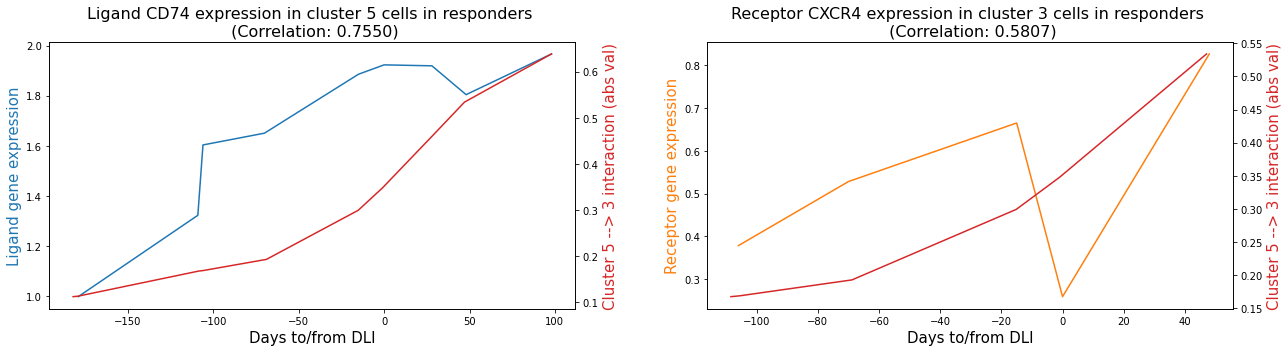

In [44]:
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_nonresponders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(ligand_days_to_dli.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
# ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_nonresponders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(receptor_days_to_dli.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
# ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('figures/AML_paper/example_top_RL_pair_R.eps')

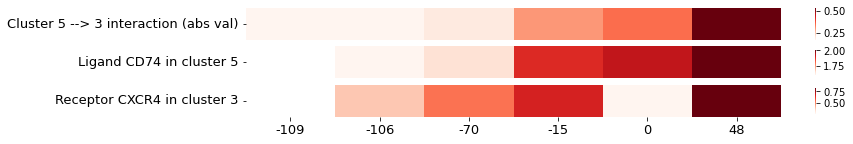

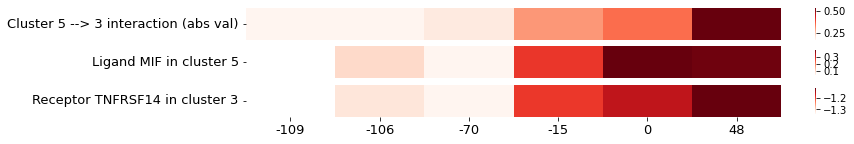

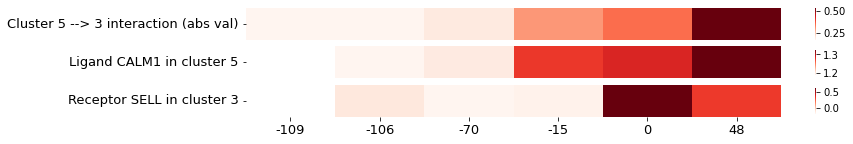

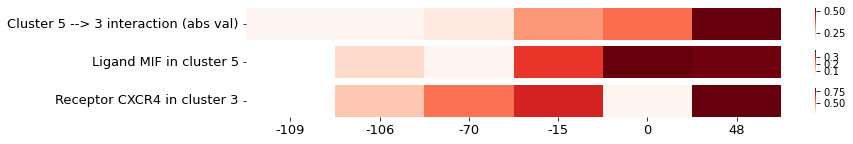

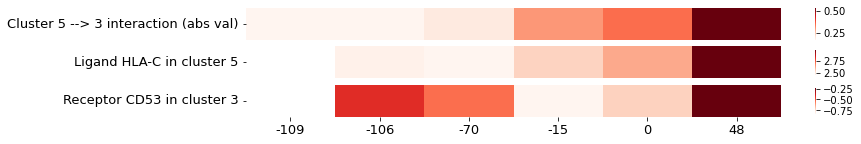

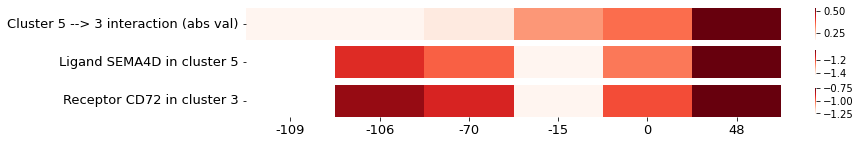

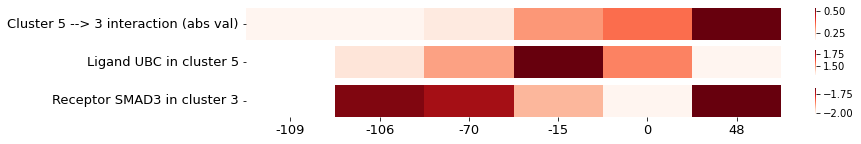

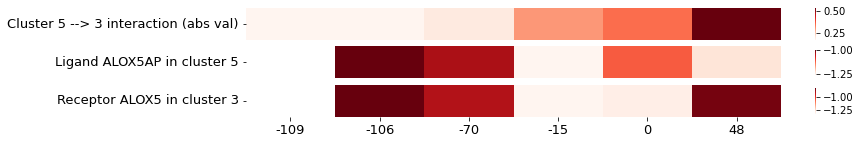

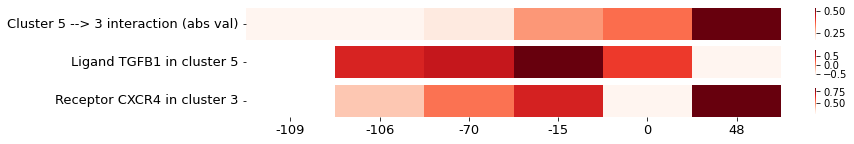

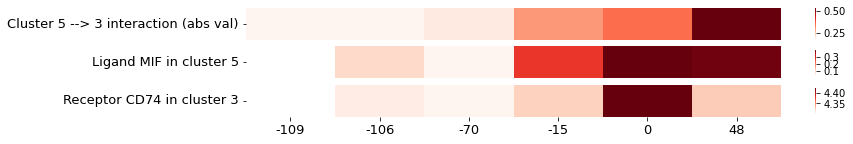

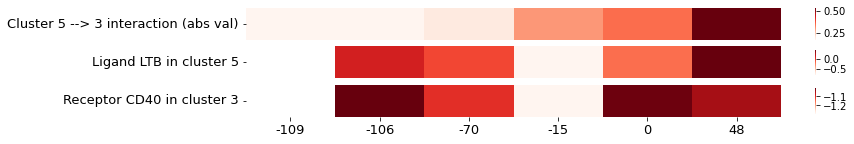

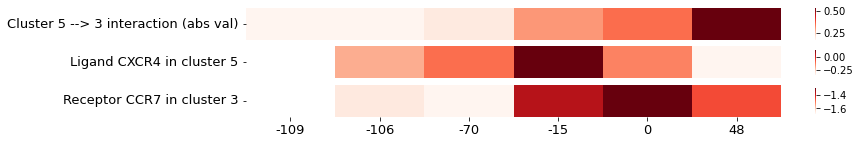

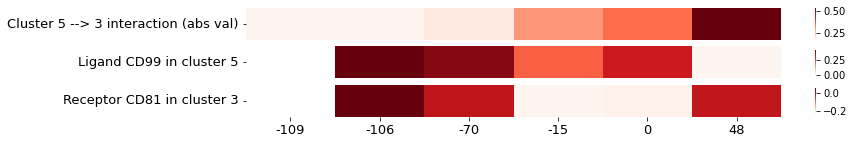

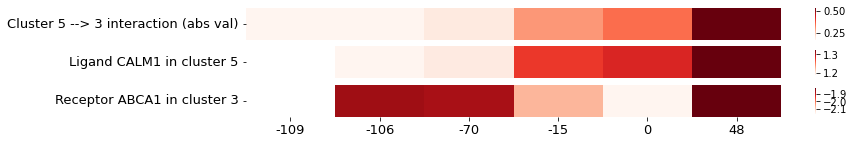

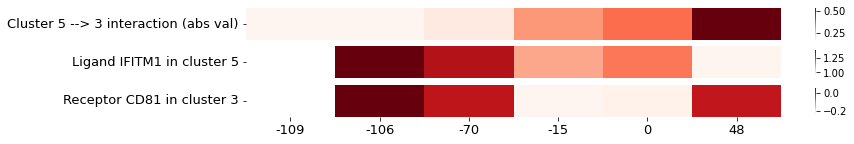

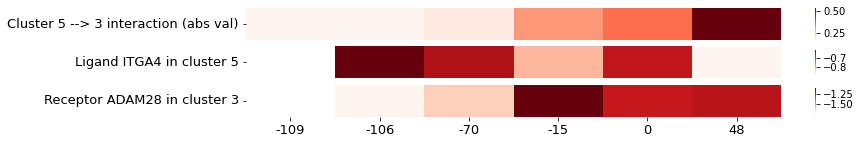

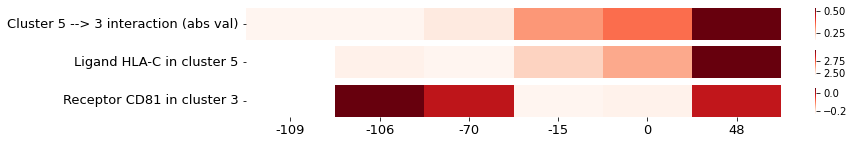

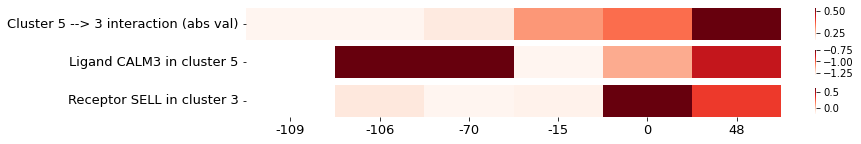

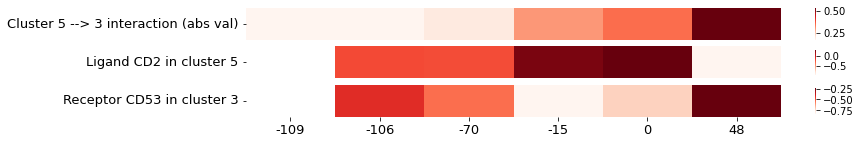

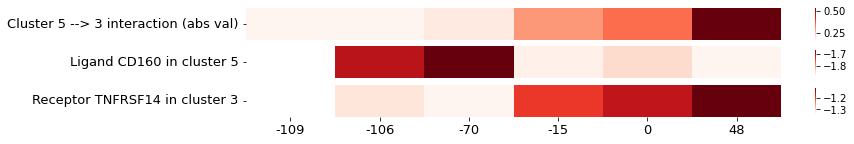

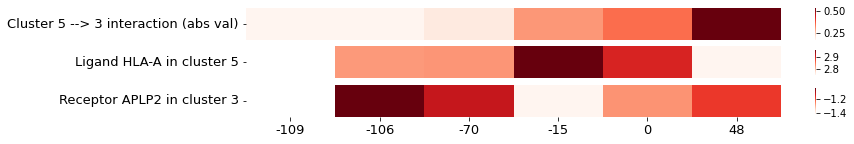

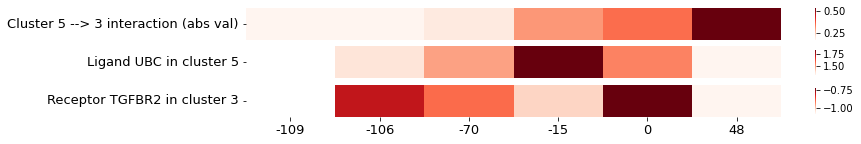

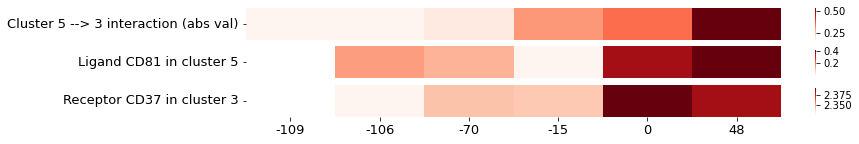

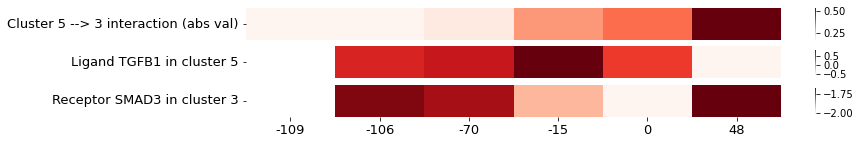

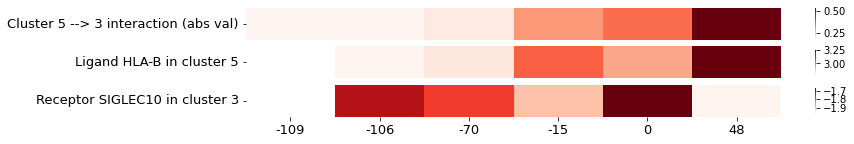

In [45]:
for index, rl_pair in ligand_receptor_corrs_with_interaction_df.head(25).iterrows():
    ligand_gene = rl_pair['Ligand']
    receptor_gene = rl_pair['Receptor']

    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_nonresponders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_nonresponders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
    
    days_to_dli = sorted(set(ligand_days_to_dli.unique()).intersection(receptor_days_to_dli.unique()))
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)

    days_to_dli = sorted(set(ligand_days_to_dli.unique()).intersection(receptor_days_to_dli.unique()))
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)

    rl_expression = pd.DataFrame(np.vstack([sliding_window_mean_ligand_gene_exp, 
                                            sliding_window_mean_receptor_gene_exp]), 
                                 columns=days_to_dli)
    rl_expression.index = [f'Ligand {ligand_gene} in cluster {source_cluster}', 
                           f'Receptor {receptor_gene} in cluster {target_cluster}']

    plt.figure(figsize=(12, 2))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 
    plt.subplot(gs[0])
    g = sns.heatmap([source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates]], 
                    xticklabels=sliding_window_mean_ligand_gene_exp.index,
                    yticklabels=[f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)'],
                    cmap='Reds', cbar_kws={"shrink": 1})
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[1])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[0]).T, cmap='Reds', cbar_kws={"shrink": 0.8})
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[2])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[1]).T, cmap='Reds', cbar_kws={"shrink": 0.8})
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels(g.get_xticklabels(), size = 13, rotation=0)

Compute RL-interaction correlations for all cluster pairs

In [46]:
min_exp_threshold = -5
sliding_window_length = 2

ligand_receptor_corrs_with_interaction = []
for source_cluster in tqdm_notebook(clusters_of_interest):
    for target_cluster in clusters_of_interest:
        if source_cluster not in cluster_to_degs or target_cluster not in cluster_to_degs: continue
        source_target_rl_corrs_with_interaction = []
        print(source_cluster, target_cluster)
        
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        source_cluster_cells = gene_exp_nonresponders_df[metadata_nonresponders_df['diisco_cluster'] == source_cluster]
        source_cluster_degs = cluster_to_degs[source_cluster]
        
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        target_cluster_cells = gene_exp_nonresponders_df[metadata_nonresponders_df['diisco_cluster'] == target_cluster]
        target_cluster_degs = cluster_to_degs[target_cluster]

        source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

        for index, rl_pair in rl_pairs.iterrows():
            ligand_gene = rl_pair['source_genesymbol']
            receptor_gene = rl_pair['target_genesymbol']
            # Filter to differentially-expressed RL genes
            if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
                continue
            # Model for ligand gene expression
            ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
            ligand_days_to_dli = metadata_nonresponders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
            days_to_dli = sorted(ligand_days_to_dli.unique())
            if len(days_to_dli) < sliding_window_length: continue
            sliding_window_mean_ligand_gene_exp = pd.Series({
                days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(days_to_dli)
            })
            ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
            for days in sliding_window_mean_ligand_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
            # Model for receptor gene expression
            receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
            receptor_days_to_dli = metadata_nonresponders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
            days_to_dli = sorted(receptor_days_to_dli.unique())
            if len(days_to_dli) < sliding_window_length: continue
            sliding_window_mean_receptor_gene_exp = pd.Series({
                days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(days_to_dli)
            })
            receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
            for days in sliding_window_mean_receptor_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
            # Correlations b/w ligand/receptor gene expression and inferred interaction
            ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                        source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])
            receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                            source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])
            source_target_rl_corrs_with_interaction.append({
                'Source cluster': source_cluster,
                'Target cluster': target_cluster,
                'Ligand': ligand_gene,
                'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
                'Ligand DEG pval': source_cluster_degs[ligand_gene],
                'Receptor': receptor_gene,
                'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
                'Receptor DEG pval': target_cluster_degs[receptor_gene],
                'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
            })
        source_target_rl_corrs_with_interaction_df = pd.DataFrame(source_target_rl_corrs_with_interaction)
        if source_target_rl_corrs_with_interaction_df.shape[0] == 0: continue
        source_target_rl_corrs_with_interaction_df = pd.merge(source_target_rl_corrs_with_interaction_df, 
                                                              rl_pairs[['source_genesymbol', 'target_genesymbol', 'n_references', 'n_sources']], 
                                                              how='left', left_on=['Ligand', 'Receptor'], 
                                                              right_on=['source_genesymbol', 'target_genesymbol'])
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.drop(columns=['source_genesymbol', 'target_genesymbol', 
                                                                                                              'Source cluster', 'Target cluster'])
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.sort_values('Avg ligand/receptor-interaction correlation', ascending=False)
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.reset_index(drop=True)
        source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.head(30)
        source_target_rl_corrs_with_interaction_df.to_excel(f'data/AML/DIISCO_AML_top_RL_pairs_NR/{source_cluster} --> {target_cluster}.xlsx', 
                                                            sheet_name='NR',
                                                            index=False)
        ligand_receptor_corrs_with_interaction.extend(source_target_rl_corrs_with_interaction)


  0%|          | 0/18 [00:00<?, ?it/s]

0 0
0 1
0 13
0 14
0 2
0 23
0 26
0 3
0 38
0 40
0 5
0 MC1
0 MC2
0 MC3
0 MC4
0 MC5
0 MC6
0 MC7
1 0
1 1
1 13
1 14
1 2
1 23
1 26
1 3
1 38
1 40
1 5
1 MC1
1 MC2
1 MC3
1 MC4
1 MC5
1 MC6
1 MC7
13 0
13 1
13 13
13 14
13 2
13 23
13 26
13 3
13 38
13 40
13 5
13 MC1
13 MC2
13 MC3
13 MC4
13 MC5
13 MC6
13 MC7
14 0
14 1
14 13
14 14
14 2
14 23
14 26
14 3
14 38
14 40
14 5
14 MC1
14 MC2
14 MC3
14 MC4
14 MC5
14 MC6
14 MC7
2 0
2 1
2 13
2 14
2 2
2 23
2 26
2 3
2 38
2 40
2 5
2 MC1
2 MC2
2 MC3
2 MC4
2 MC5
2 MC6
2 MC7
23 0
23 1
23 13
23 14
23 2
23 23
23 26
23 3
23 38
23 40
23 5
23 MC1
23 MC2
23 MC3
23 MC4
23 MC5
23 MC6
23 MC7
26 0
26 1
26 13
26 14
26 2
26 23
26 26
26 3
26 38
26 40
26 5
26 MC1
26 MC2
26 MC3
26 MC4
26 MC5
26 MC6
26 MC7
3 0
3 1
3 13
3 14
3 2
3 23
3 26
3 3
3 38
3 40
3 5
3 MC1
3 MC2
3 MC3
3 MC4
3 MC5
3 MC6
3 MC7
38 0
38 1
38 13
38 14
38 2
38 23
38 26
38 3
38 38
38 40
38 5
38 MC1
38 MC2
38 MC3
38 MC4
38 MC5
38 MC6
38 MC7
40 0
40 1
40 13
40 14
40 2
40 23
40 26
40 3
40 38
40 40
40 5
40 MC1
40 MC2
40 MC3


In [84]:
ligand_receptor_corrs_with_interaction_df = pd.DataFrame(ligand_receptor_corrs_with_interaction)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.\
    sort_values(['Source cluster', 'Target cluster', 'Avg ligand/receptor-interaction correlation'], 
                ascending= [True, True, False])
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.dropna()
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.reset_index(drop=True)
ligand_receptor_corrs_with_interaction_df.to_csv('data/AML/rl_interaction_correlations_NR.csv', index=False)
ligand_receptor_corrs_with_interaction_df

,Source cluster,Target cluster,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,0,1,ADGRE5,0.447769,9.411939e-66,CD55,0.620071,1.105340e-95,0.533920
1,0,1,PPP2R2B,0.698733,8.781995e-81,TGFBR2,0.096105,8.779904e-71,0.397419
2,0,1,TGFB1,0.609995,0.000000e+00,TGFBR2,0.096105,8.779904e-71,0.353050
3,0,1,JAK1,0.244608,1.079878e-219,IFNAR1,0.451912,9.383928e-20,0.348260
4,0,1,CD160,0.580548,2.117694e-29,TNFRSF14,0.056345,2.200182e-27,0.318446
...,...,...,...,...,...,...,...,...,...
15342,45,26,HLA-C,-0.629594,2.624152e-14,LILRA1,0.071274,7.075015e-125,-0.279160
15343,45,26,ITGB2,-0.267699,2.221315e-06,ICAM1,-0.484664,3.438137e-03,-0.376181
15344,45,26,CCL5,-0.597303,3.150873e-124,CCR1,-0.155979,2.467638e-03,-0.376641
15345,45,26,HLA-C,-0.629594,2.624152e-14,LILRB2,-0.219046,1.245464e-278,-0.424320


In [85]:
ligand_receptor_corrs_with_interaction_df = pd.read_csv('data/AML/rl_interaction_correlations_NR.csv')
ligand_receptor_corrs_with_interaction_df

,Source cluster,Target cluster,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,0,1,ADGRE5,0.447769,9.411939e-66,CD55,0.620071,1.105340e-95,0.533920
1,0,1,PPP2R2B,0.698733,8.781995e-81,TGFBR2,0.096105,8.779904e-71,0.397419
2,0,1,TGFB1,0.609995,0.000000e+00,TGFBR2,0.096105,8.779904e-71,0.353050
3,0,1,JAK1,0.244608,1.079878e-219,IFNAR1,0.451912,9.383928e-20,0.348260
4,0,1,CD160,0.580548,2.117694e-29,TNFRSF14,0.056345,2.200182e-27,0.318446
...,...,...,...,...,...,...,...,...,...
15342,45,26,HLA-C,-0.629594,2.624152e-14,LILRA1,0.071274,7.075015e-125,-0.279160
15343,45,26,ITGB2,-0.267699,2.221315e-06,ICAM1,-0.484664,3.438137e-03,-0.376181
15344,45,26,CCL5,-0.597303,3.150873e-124,CCR1,-0.155979,2.467638e-03,-0.376641
15345,45,26,HLA-C,-0.629594,2.624152e-14,LILRB2,-0.219046,1.245464e-278,-0.424320


### Agreement between DIISCO and CellPhoneDB

In [86]:
cellphonedb_aml_nr_pre = pd.read_csv('data/AML/cellphonedb_output/aml_nr_pre-2.csv', index_col='Unnamed: 0')
cellphonedb_aml_nr_pre['cluster_L'] = cellphonedb_aml_nr_pre['cluster_L'].str.split('_').str[1].astype(int)
cellphonedb_aml_nr_pre['cluster_R'] = cellphonedb_aml_nr_pre['cluster_R'].str.split('_').str[1].astype(int)
cellphonedb_aml_nr_pre = cellphonedb_aml_nr_pre[(cellphonedb_aml_nr_pre['cluster_L'].isin(clusters_of_interest)) & 
                                                (cellphonedb_aml_nr_pre['cluster_R'].isin(clusters_of_interest))]
cellphonedb_aml_nr_pre['p-val'] = -np.log1p(cellphonedb_aml_nr_pre['p-val'])
cellphonedb_aml_nr_pre

,cluster_L,cluster_R,Ligand,Receptor,mean_logexp_L,mean_logexp_R,p-val
0,0,1,CCL4,CNR2,-0.429541,-2.068809,-0.0
1,0,1,CD52,SIGLEC10,1.987244,-2.107780,-0.0
2,0,1,PTPRC,CD22,0.454621,-0.998551,-0.0
3,0,1,CD160,TNFRSF14,-1.882195,-1.575845,-0.0
4,0,1,TNFSF14,TNFRSF14,-2.167527,-1.575845,-0.0
...,...,...,...,...,...,...,...
17431,8,7,PLXNB2,SEMA4D,-2.066142,-1.908303,-0.0
17432,8,7,ICAM2,aLb2 complex,NaN,NaN,-0.0
17433,8,7,ICAM3,aLb2 complex,NaN,NaN,-0.0
17434,8,7,LGALS9,CD44,-1.803414,-0.977957,-0.0


In [87]:
num_sig_interactions_by_clusters_pre = []

for i, group in cellphonedb_aml_nr_pre.groupby(['cluster_L', 'cluster_R']):
    source_cluster, target_cluster = i
    num_sig_interactions = group.shape[0]
    num_sig_interactions_by_clusters_pre.append({
        'Source cluster': source_cluster,
        'Target cluster': target_cluster,
        'Number of significant interactions': num_sig_interactions,
        'Average -log(p-value)': group['p-val'].mean(),
        'Average RL log exp': group[['mean_logexp_L', 'mean_logexp_R']].mean().mean()
    })
    
num_sig_interactions_by_clusters_pre = pd.DataFrame(num_sig_interactions_by_clusters_pre)
num_sig_interactions_by_clusters_pre.sort_values('Number of significant interactions', ascending=False).head(10)

,Source cluster,Target cluster,Number of significant interactions,Average -log(p-value),Average RL log exp
316,26,2,42,-0.003384,-1.288635
327,26,21,39,-0.000708,-1.307978
94,4,26,38,-0.001558,-1.251266
269,21,26,36,-0.002744,-0.961889
370,29,26,35,-0.000909,-1.027012
91,4,21,35,-0.000313,-1.498524
233,16,26,34,-0.002525,-1.353803
74,3,26,34,-0.001166,-1.416366
62,3,2,34,0.000000,-1.428527
220,16,2,34,-0.000352,-1.672665


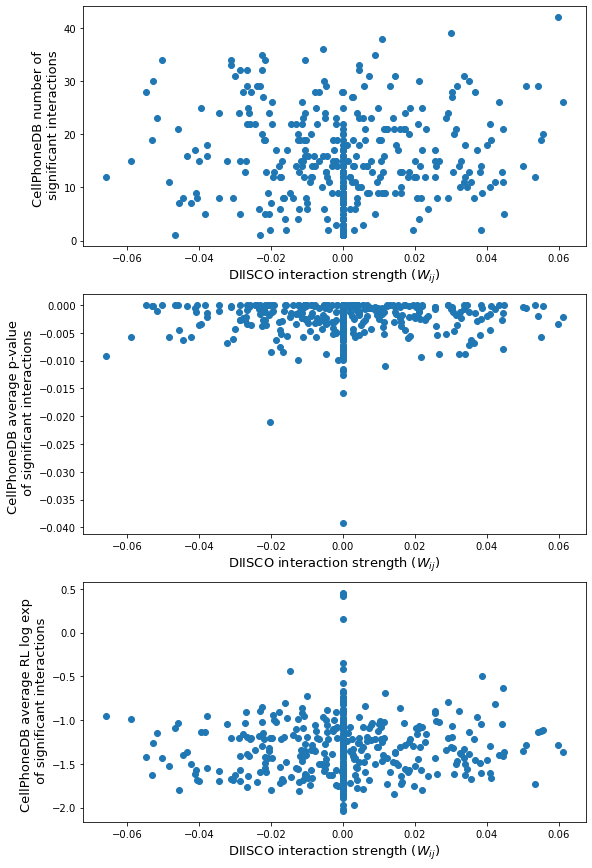

In [88]:
plt.figure(figsize=(9, 15)) 

plt.subplot(3, 1, 1)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Number of significant interactions'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB number of \n significant interactions', fontsize=13)
        
plt.subplot(3, 1, 2)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average p-value \n of significant interactions', fontsize=13)
        
plt.subplot(3, 1, 3)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average RL log exp'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average RL log exp \n of significant interactions', fontsize=13)

In [89]:
cellphonedb_aml_nr_post = pd.read_csv('data/AML/cellphonedb_output/aml_nr_post-2.csv', index_col='Unnamed: 0')
cellphonedb_aml_nr_post['cluster_L'] = cellphonedb_aml_nr_post['cluster_L'].str.split('_').str[1].astype(int)
cellphonedb_aml_nr_post['cluster_R'] = cellphonedb_aml_nr_post['cluster_R'].str.split('_').str[1].astype(int)
cellphonedb_aml_nr_post = cellphonedb_aml_nr_post[(cellphonedb_aml_nr_post['cluster_L'].isin(clusters_of_interest)) & 
                                                  (cellphonedb_aml_nr_post['cluster_R'].isin(clusters_of_interest))]
cellphonedb_aml_nr_post['p-val'] = -np.log1p(cellphonedb_aml_nr_post['p-val'])
cellphonedb_aml_nr_post

,cluster_L,cluster_R,Ligand,Receptor,mean_logexp_L,mean_logexp_R,p-val
0,0,1,CCL4,CNR2,-0.429541,-2.068809,-0.000000
1,0,1,ADRB2,VEGFB,-1.920954,-1.993654,-0.007968
2,0,1,IFNG,Type II IFNR,NaN,NaN,-0.015873
3,0,1,PTPRC,CD22,0.454621,-0.998551,-0.000000
4,0,1,ADGRG5,FAM3C,-2.137795,-1.790596,-0.003992
...,...,...,...,...,...,...,...
13620,8,7,PLXNB2,SEMA4D,-2.066142,-1.908303,-0.023717
13621,8,7,LTBR,LTB,-2.126006,-0.709210,-0.007968
13622,8,7,PLAUR,a4b1 complex,NaN,NaN,-0.046884
13623,8,7,CD47,SIRPG,-1.820132,-1.919782,-0.003992


In [90]:
num_sig_interactions_by_clusters_post = []

for i, group in cellphonedb_aml_nr_post.groupby(['cluster_L', 'cluster_R']):
    source_cluster, target_cluster = i
    num_sig_interactions = group.shape[0]
    num_sig_interactions_by_clusters_post.append({
        'Source cluster': source_cluster,
        'Target cluster': target_cluster,
        'Number of significant interactions': num_sig_interactions,
        'Average -log(p-value)': group['p-val'].mean(),
        'Average RL log exp': group[['mean_logexp_L', 'mean_logexp_R']].mean().mean()
    })
    
num_sig_interactions_by_clusters_post = pd.DataFrame(num_sig_interactions_by_clusters_post)
num_sig_interactions_by_clusters_post.sort_values('Number of significant interactions', ascending=False).head(10)

,Source cluster,Target cluster,Number of significant interactions,Average -log(p-value),Average RL log exp
237,21,2,48,-0.001939,-1.356019
239,21,4,40,-0.001950,-1.169410
248,21,23,32,-0.004277,-1.071156
258,23,4,32,-0.006248,-1.121880
312,29,2,32,-0.008816,-1.346231
124,7,21,32,-0.019312,-1.591506
249,21,26,30,-0.007559,-0.837023
250,21,28,30,-0.001701,-1.215716
186,15,2,30,-0.007218,-1.134964
114,7,2,29,-0.020050,-1.592476


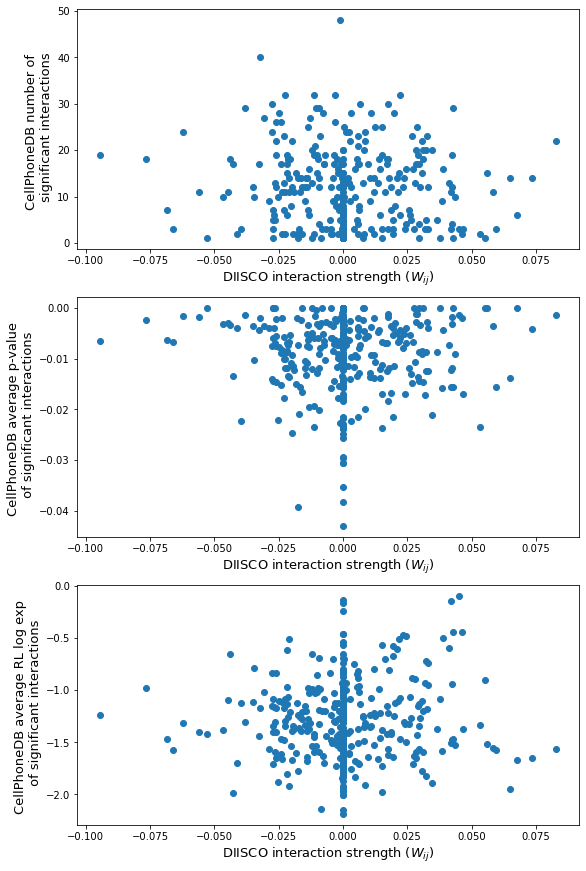

In [91]:
plt.figure(figsize=(9, 15)) 

plt.subplot(3, 1, 1)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Number of significant interactions'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB number of \n significant interactions', fontsize=13)
        
plt.subplot(3, 1, 2)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average p-value \n of significant interactions', fontsize=13)
        
plt.subplot(3, 1, 3)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average RL log exp'], 
                    color='tab:blue')
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average RL log exp \n of significant interactions', fontsize=13)

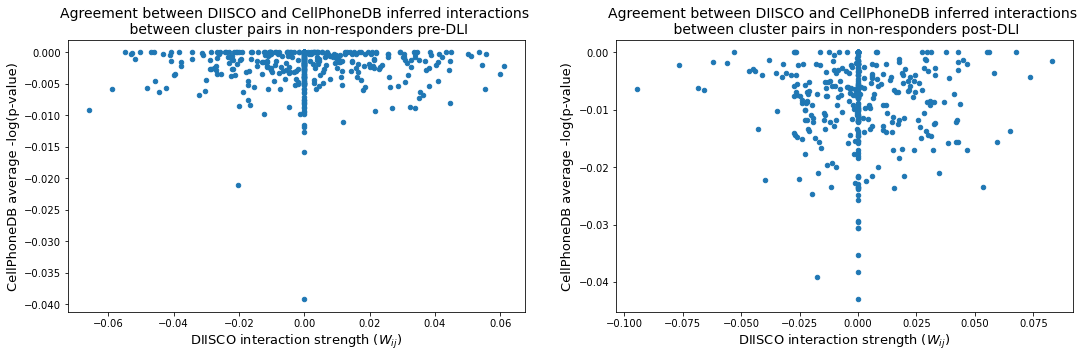

In [92]:
plt.figure(figsize=(18, 5)) 

plt.subplot(1, 2, 1)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=20)
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in non-responders pre-DLI', 
                  fontsize=14)
        
plt.subplot(1, 2, 2)
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=20)
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in non-responders post-DLI', 
                  fontsize=14)
        
# plt.savefig('figures/AML_paper/agreement_diisco_cellphonedb_NR.eps')

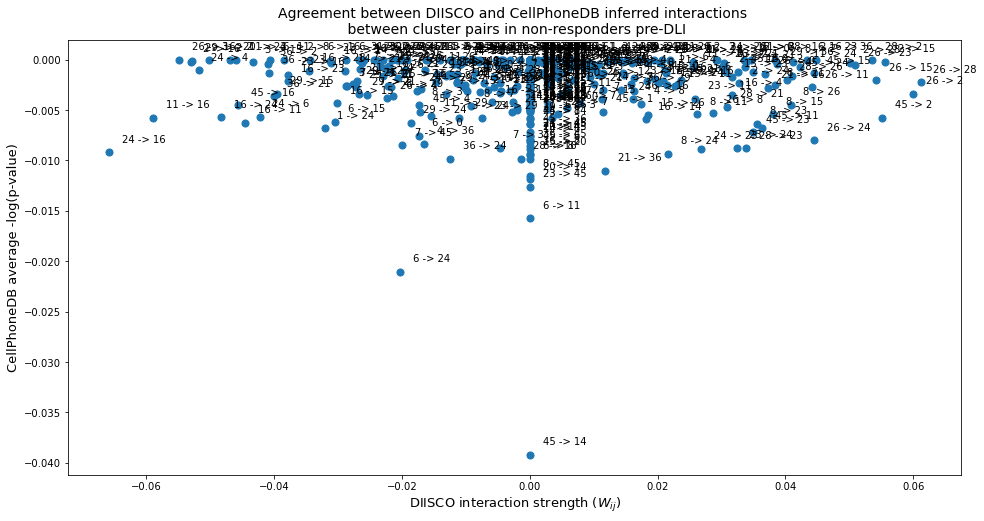

In [93]:
plt.figure(figsize=(16, 8)) 
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_pre[(num_sig_interactions_by_clusters_pre['Source cluster'] == source_cluster) & 
                                                 (num_sig_interactions_by_clusters_pre['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=50)
        plt.annotate(f'{source_cluster} -> {target_cluster}', 
                     (W_pre_dli_avg_over_time[target_cluster_index, source_cluster_index] + 0.002, 
                      cellphonedb_cluster_pair['Average -log(p-value)'] + 0.001,))
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in non-responders pre-DLI', 
                  fontsize=14)

# plt.savefig('figures/AML_paper/agreement_diisco_cellphonedb_pre_NR.eps')

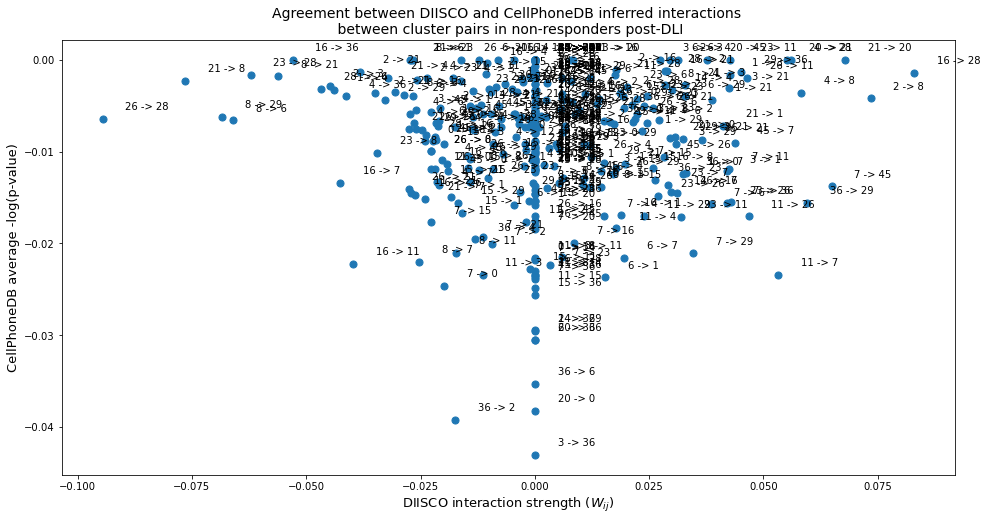

In [94]:
plt.figure(figsize=(16, 8)) 
for source_cluster in clusters_of_interest:
    for target_cluster in clusters_of_interest:
        cellphonedb_cluster_pair =\
            num_sig_interactions_by_clusters_post[(num_sig_interactions_by_clusters_post['Source cluster'] == source_cluster) & 
                                                  (num_sig_interactions_by_clusters_post['Target cluster'] == target_cluster)]
        if cellphonedb_cluster_pair.shape[0] == 0: continue
        source_cluster_index = list(clusters_of_interest).index(source_cluster)
        target_cluster_index = list(clusters_of_interest).index(target_cluster)
        plt.scatter(W_post_dli_avg_over_time[target_cluster_index, source_cluster_index], 
                    cellphonedb_cluster_pair['Average -log(p-value)'], 
                    color='tab:blue', s=50)
        plt.annotate(f'{source_cluster} -> {target_cluster}', 
                     (W_post_dli_avg_over_time[target_cluster_index, source_cluster_index] + 0.005, 
                      cellphonedb_cluster_pair['Average -log(p-value)'] + 0.001,))
        plt.xlabel('DIISCO interaction strength ($W_{ij}$)', fontsize=13)
        plt.ylabel('CellPhoneDB average -log(p-value)', fontsize=13)
        plt.title('Agreement between DIISCO and CellPhoneDB inferred interactions \n between cluster pairs in non-responders post-DLI', 
                  fontsize=14)
        
# plt.savefig('figures/AML_paper/agreement_diisco_cellphonedb_post_NR.eps')

## Misc

In [37]:
rl_pairs[rl_pairs['target_genesymbol'] == 'TIGIT']

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
1071,P15151,Q495A1,PVR,TIGIT,True,True,False,False,False,False,7,CellPhoneDB:19815499;ICELLNET:27192565;IntAct:...,CellChatDB;CellPhoneDB;ICELLNET;IntAct;LRdb;Li...,19815499;21982860;27192565;28515320;30591568,5,10,9
1597,Q92692,Q495A1,NECTIN2,TIGIT,True,True,False,False,False,False,6,ICELLNET:27192565;IntAct:21982860;IntAct:27978...,CellChatDB;ICELLNET;IntAct;Lit-BM-17;connectom...,19815499;21982860;27192565;27978489;28515320,5,5,5
1600,Q9NQS3,Q495A1,NECTIN3,TIGIT,True,True,False,True,True,False,5,CellChatDB:1313846;CellPhoneDB:1313846;Cellink...,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;C...,1313846;21982860;26927206;30759143,4,8,6
5642,Q96NY8,Q495A1,NECTIN4,TIGIT,True,False,False,False,False,False,3,Cellinker:32589946;Lit-BM-17:21982860;connecto...,Cellinker;Lit-BM-17;connectomeDB2020,21982860;32503945;32589946,3,3,3
6189,O95980,Q495A1,RECK,TIGIT,True,False,False,False,False,False,1,Cellinker:32589946,Cellinker,32589946,1,1,1
6451,P78324,Q495A1,SIRPA,TIGIT,True,False,False,False,False,False,1,Cellinker:32589946,Cellinker,32589946,1,1,1
6876,P12318,Q495A1,FCGR2A,TIGIT,True,False,False,False,False,False,1,Cellinker:32822567,Cellinker;Wojtowicz2020,32822567,1,2,2


Text(0.5, 1.0, 'TIGIT expression distribution by cluster')

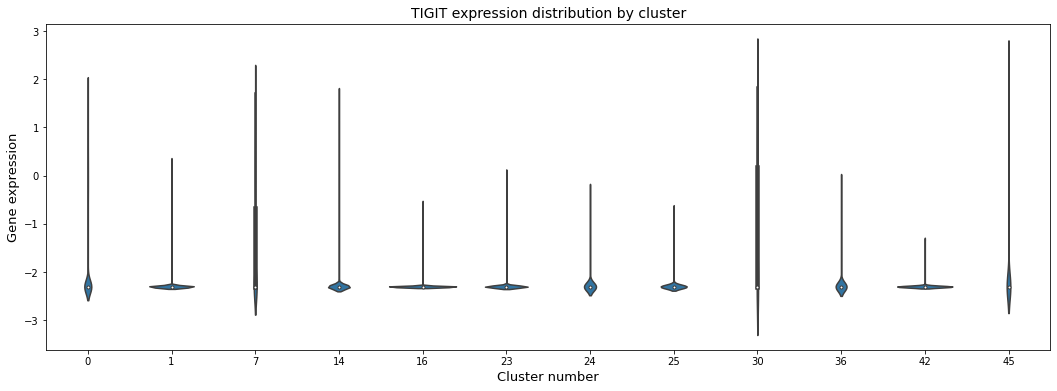

In [42]:
plt.figure(figsize=(18, 6))
sns.violinplot(x='cluster_number', y='TIGIT', color='tab:blue', 
               data=gene_exp_df[gene_exp_df['cluster_number'].isin(clusters_of_interest)])
plt.xlabel('Cluster number', fontsize=13)
plt.ylabel('Gene expression', fontsize=13)
plt.title('TIGIT expression distribution by cluster', fontsize=14)

Text(0.5, 1.0, 'NECTIN2 expression distribution by cluster')

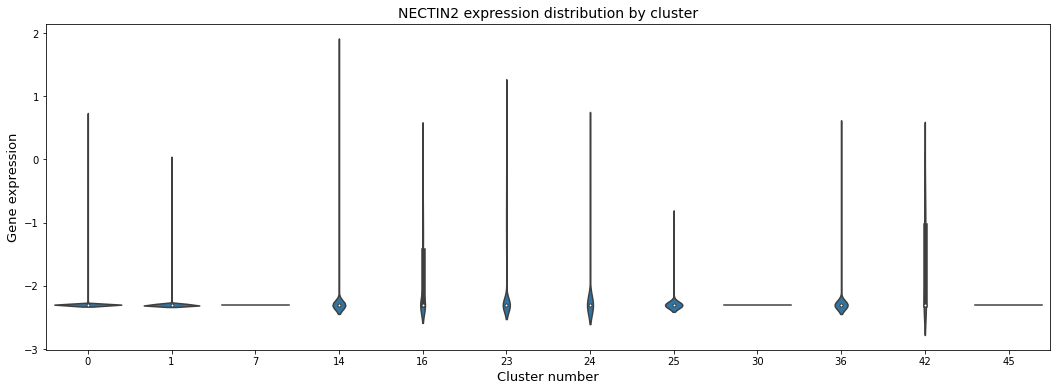

In [51]:
plt.figure(figsize=(18, 6))
sns.violinplot(x='cluster_number', y='NECTIN2', color='tab:blue', 
               data=gene_exp_df[gene_exp_df['cluster_number'].isin(clusters_of_interest)])
plt.xlabel('Cluster number', fontsize=13)
plt.ylabel('Gene expression', fontsize=13)
plt.title('NECTIN2 expression distribution by cluster', fontsize=14)

In [54]:
rl_pairs[rl_pairs['target_genesymbol'] == 'HAVCR2']

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
1420,P13688,Q8TDQ0,CEACAM1,HAVCR2,True,False,False,False,False,False,4,ICELLNET:25363763;ICELLNET:27192565;InnateDB:2...,ICELLNET;InnateDB;connectomeDB2020,25363763;26982724;27192565,3,3,3
1502,P09429,Q8TDQ0,HMGB1,HAVCR2,True,False,False,False,False,False,4,Cellinker:23519706;ICELLNET:22842346;ICELLNET:...,Cellinker;ICELLNET;connectomeDB2020,22842346;23519706;27192565,3,3,3
1585,O00182,Q8TDQ0,LGALS9,HAVCR2,True,False,False,False,False,False,9,CellChatDB:27192565;CellPhoneDB:27192565;CellT...,CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;C...,16286920;22437870;23967307;27192565,4,10,9


Text(0.5, 1.0, 'HAVCR2 expression distribution by cluster')

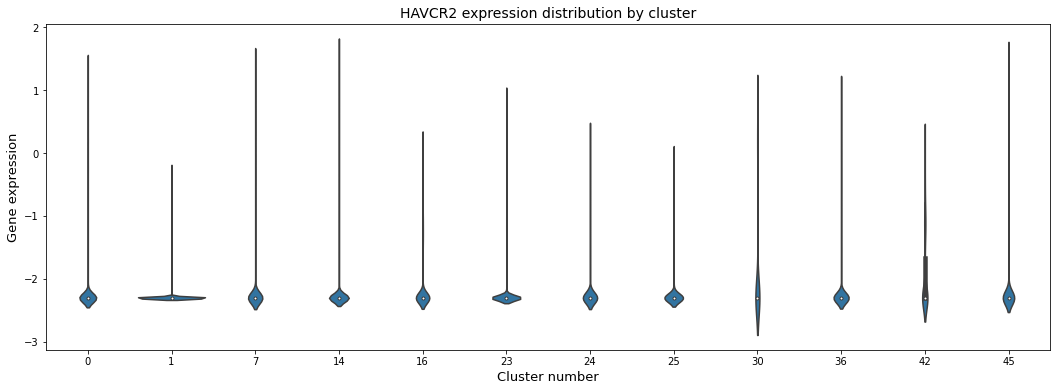

In [55]:
plt.figure(figsize=(18, 6))
sns.violinplot(x='cluster_number', y='HAVCR2', color='tab:blue', 
               data=gene_exp_df[gene_exp_df['cluster_number'].isin(clusters_of_interest)])
plt.xlabel('Cluster number', fontsize=13)
plt.ylabel('Gene expression', fontsize=13)
plt.title('HAVCR2 expression distribution by cluster', fontsize=14)

Text(0.5, 1.0, 'LGALS9 expression distribution by cluster')

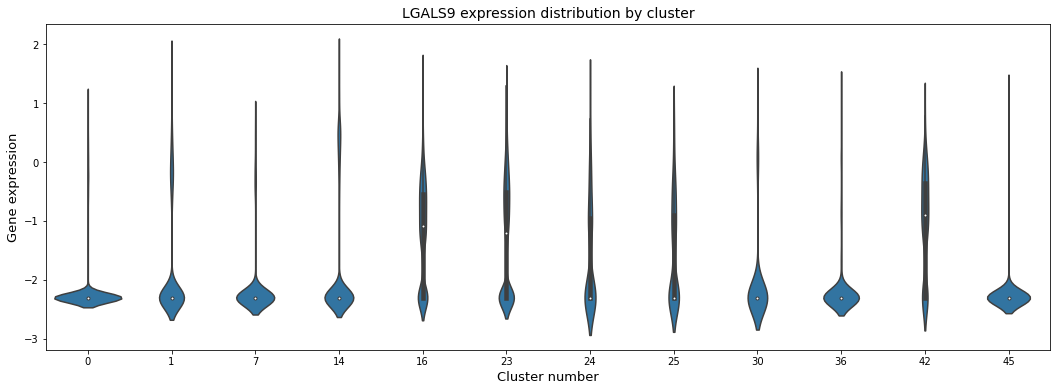

In [56]:
plt.figure(figsize=(18, 6))
sns.violinplot(x='cluster_number', y='LGALS9', color='tab:blue', 
               data=gene_exp_df[gene_exp_df['cluster_number'].isin(clusters_of_interest)])
plt.xlabel('Cluster number', fontsize=13)
plt.ylabel('Gene expression', fontsize=13)
plt.title('LGALS9 expression distribution by cluster', fontsize=14)